In [1]:
import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from collections import Counter

!pip install missingno statsmodels
import missingno as msno

import xgboost as xgb
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve
import torch

import warnings
warnings.filterwarnings("ignore")

/kaggle/input/rocket-mortgage/train (1).csv
/kaggle/input/rocket-mortgage/test (1).csv


# Util Functions

In [2]:
def get_null_percentage(df):
    """
    Returns a Pandas Series containing the percentage of null values for each column in the DataFrame.
    
    Parameters:
        df (pd.DataFrame): The DataFrame to analyze.
    
    Returns:
        pd.Series: A series with column names as index and null percentages as values.
    """
    null_percentage = (df.isnull().sum() / len(df)) * 100
    return null_percentage[null_percentage > 0].sort_values(ascending=False)

In [3]:
def fill_mort_acc(row):
    if pd.isna(row['mort_acc']):
        return mort_acc_medians.get(row['total_acc'], train_df['mort_acc'].median())
    else:
        return row['mort_acc']

In [4]:
def convert_emp_length(emp):
    """
    Converts employment length from string to a numeric value:
      - "10+ years" becomes 10
      - "< 1 year" becomes 0
      - "X years" becomes X as an integer
    If emp is null, it returns "Unknown".
    """
    if pd.isnull(emp):
        return "Unknown"
    emp = emp.strip()
    if emp == "10+ years":
        return 10
    elif emp == "< 1 year":
        return 0
    else:
        try:
            return int(emp.split()[0])
        except ValueError:
            return "Unknown"

# Importing the data & basic checks

In [5]:
train_df=pd.read_csv('/kaggle/input/rocket-mortgage/train (1).csv')
train_df.shape

(316970, 28)

In [6]:
train_df.head()

,Unnamed: 0,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,0,6400.0,36 months,15.61,223.78,C,C3,Accountant,< 1 year,RENT,...,12.0,0.0,31228.0,97.6,22.0,f,INDIVIDUAL,0.0,0.0,"354 Palmer Cove\r\nWest Alexa, SD 48052"
1,1,25000.0,60 months,19.99,662.21,E,E1,Electronic Technician,10+ years,MORTGAGE,...,18.0,1.0,24755.0,42.1,64.0,f,INDIVIDUAL,7.0,1.0,"8778 Lopez Street\r\nNew Jacqueline, TN 05113"
2,2,15000.0,36 months,5.32,451.73,A,A1,Transportation Coordinator,10+ years,MORTGAGE,...,12.0,0.0,8925.0,23.3,23.0,w,INDIVIDUAL,4.0,0.0,"21752 William Forest\r\nJeremyberg, WA 05113"
3,3,16000.0,36 months,15.61,559.44,C,C3,ironworker,< 1 year,RENT,...,8.0,0.0,6972.0,79.2,17.0,f,INDIVIDUAL,0.0,0.0,"2707 Brittany Prairie Apt. 007\r\nThomasville,..."
4,4,8725.0,36 months,12.12,290.30,B,B3,Hathaway-Sycamores child & Family Serv,10+ years,MORTGAGE,...,10.0,0.0,25397.0,45.8,32.0,f,INDIVIDUAL,7.0,0.0,"PSC 1131, Box 5667\r\nAPO AA 00813"


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316970 entries, 0 to 316969
Data columns (total 28 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Unnamed: 0            316970 non-null  int64  
 1   loan_amnt             316970 non-null  float64
 2   term                  316970 non-null  object 
 3   int_rate              316970 non-null  float64
 4   installment           316970 non-null  float64
 5   grade                 316970 non-null  object 
 6   sub_grade             316970 non-null  object 
 7   emp_title             298572 non-null  object 
 8   emp_length            302294 non-null  object 
 9   home_ownership        316970 non-null  object 
 10  annual_inc            316970 non-null  float64
 11  verification_status   316970 non-null  object 
 12  issue_d               316970 non-null  object 
 13  loan_status           316970 non-null  object 
 14  purpose               316970 non-null  object 
 15  

In [8]:
train_df['loan_status'].value_counts(normalize=True)

loan_status
Fully Paid     0.803335
Charged Off    0.196665
Name: proportion, dtype: float64

# Data Cleaning

In [9]:
get_null_percentage(train_df)

mort_acc                9.533079
emp_title               5.804335
emp_length              4.630091
title                   0.440736
pub_rec_bankruptcies    0.135660
revol_util              0.067199
dtype: float64

In [10]:
train_df.isnull().sum()

Unnamed: 0                  0
loan_amnt                   0
term                        0
int_rate                    0
installment                 0
grade                       0
sub_grade                   0
emp_title               18398
emp_length              14676
home_ownership              0
annual_inc                  0
verification_status         0
issue_d                     0
loan_status                 0
purpose                     0
title                    1397
dti                         0
earliest_cr_line            0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                213
total_acc                   0
initial_list_status         0
application_type            0
mort_acc                30217
pub_rec_bankruptcies      430
address                     0
dtype: int64

In [11]:
train_df.drop(['Unnamed: 0'],axis=1,inplace=True)

**Handling mort_acc Null Values**
* Since total_acc and mort_acc are correlated and the missingness follows MAR (Missing at Random) pattern, we can impute it with the median of total_acc.
* Performing a group by to compute the median of the respective correlated total_acc.

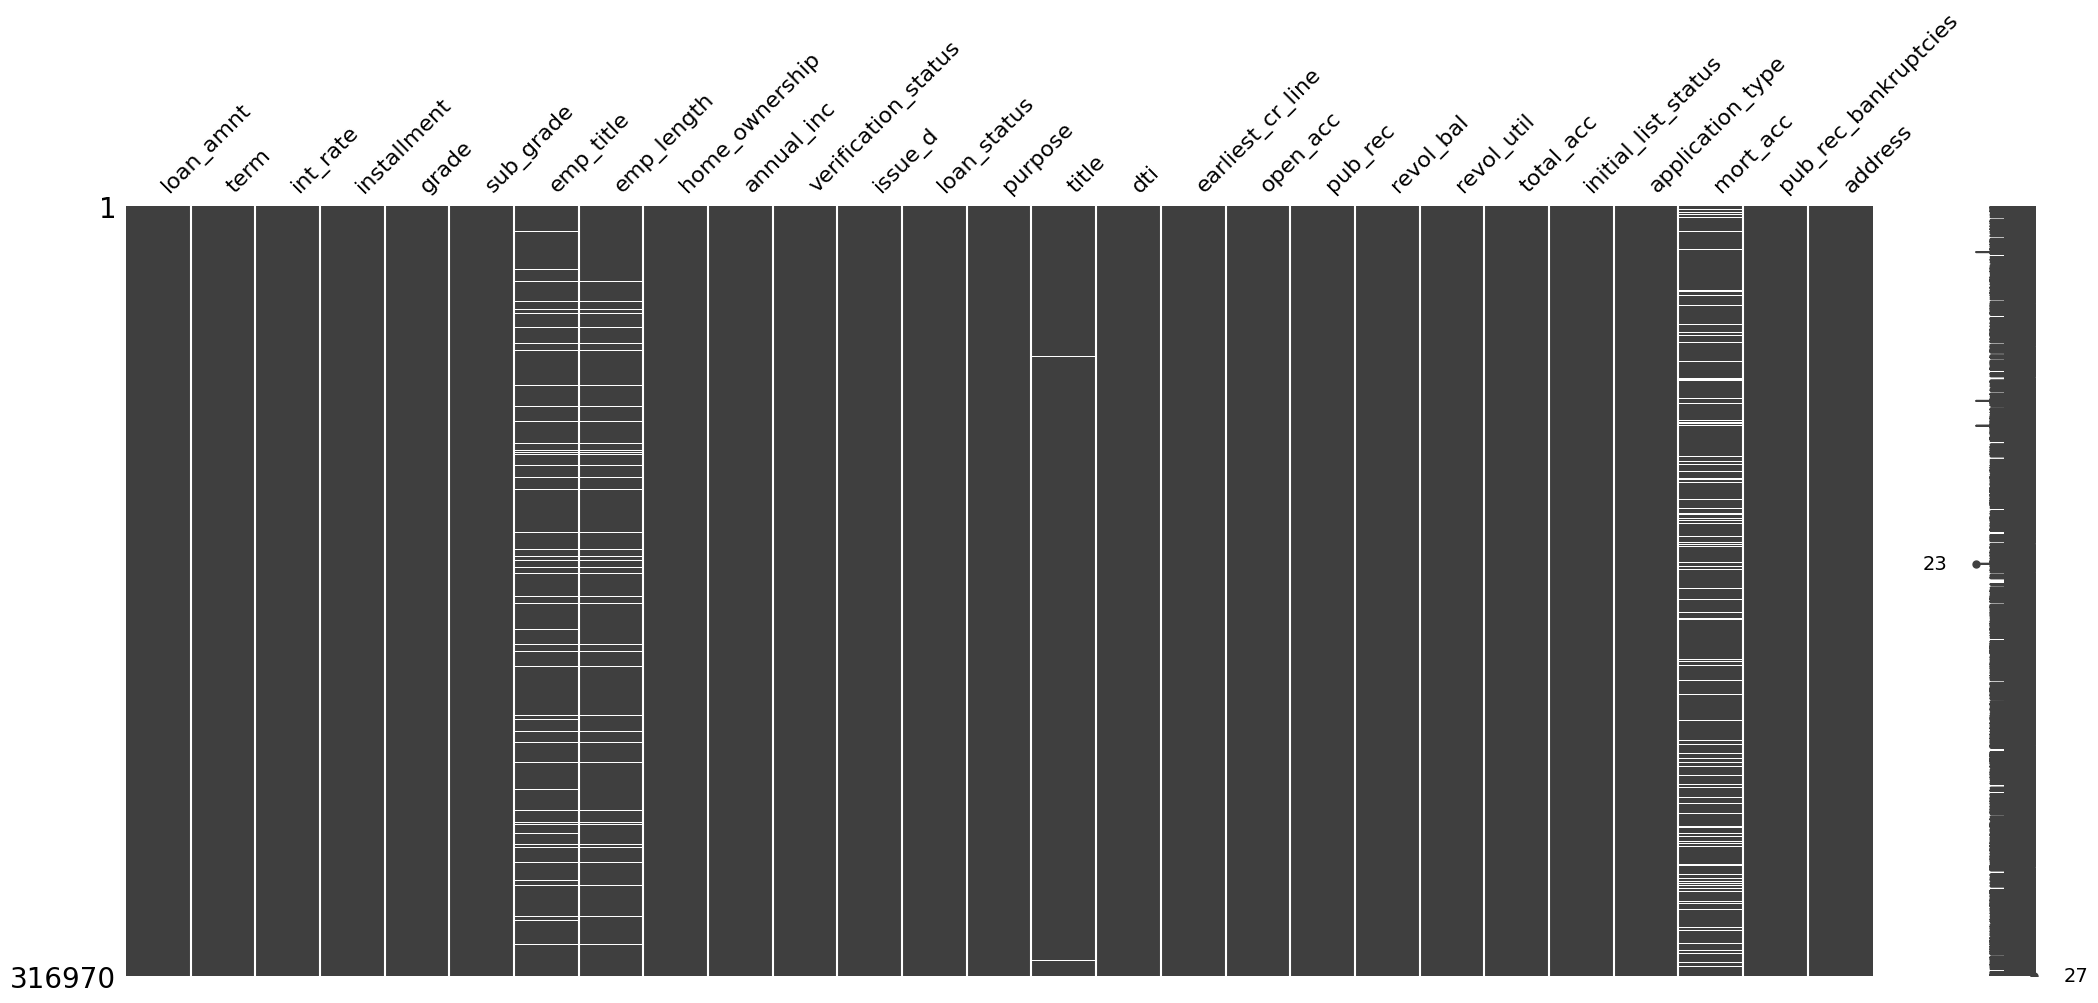

In [12]:
msno.matrix(train_df)
plt.show()

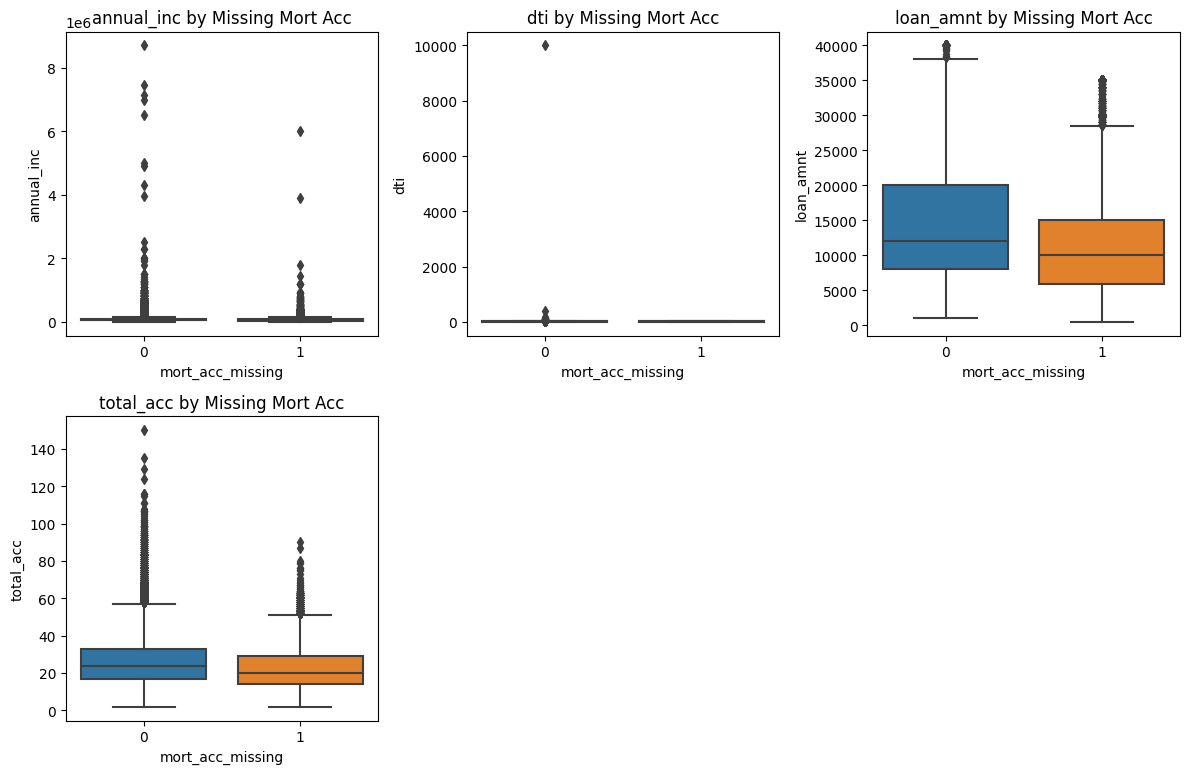

In [13]:
train_df['mort_acc_missing'] = train_df['mort_acc'].isnull().astype(int)

features_to_check = ['annual_inc', 'dti', 'loan_amnt', 'total_acc']

plt.figure(figsize=(12, 8))
for i, feature in enumerate(features_to_check, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='mort_acc_missing', y=feature, data=train_df)
    plt.title(f'{feature} by Missing Mort Acc')

plt.tight_layout()
plt.show()

In [14]:
mort_acc_medians = train_df.groupby('total_acc')['mort_acc'].median()
train_df['mort_acc'] = train_df.apply(fill_mort_acc, axis=1)
train_df['mort_acc'].isnull().sum()

0

In [15]:
train_df.shape

(316970, 28)

**Handling employment title and title**
* Dropping both the features as they are not necessary for the model to pick up patterns.

In [16]:
train_df['emp_title'].nunique()

143510

In [17]:
train_df['title'].nunique()

40375

In [18]:
train_df[['emp_title','title']].head()

,emp_title,title
0,Accountant,Loan Consolidation!! Thank you!!
1,Electronic Technician,Debt consolidation
2,Transportation Coordinator,Debt consolidation
3,ironworker,pay off debt
4,Hathaway-Sycamores child & Family Serv,bill pay


In [19]:
train_df.drop(['emp_title','title'], axis=1, inplace=True)
train_df.shape

(316970, 26)

**Handling Revolving Utilization Nulls**
* Dropping the records as it accounts <0.07 % of total records.
* Also ensuring the distribution of target in those records, as we aldready have highly imbalanced target.

In [20]:
revol_df=train_df[train_df['revol_util'].isnull()].copy()
revol_df.shape

(213, 26)

In [21]:
revol_df['loan_status'].value_counts(normalize=False)

loan_status
Fully Paid     165
Charged Off     48
Name: count, dtype: int64

In [22]:
train_df.dropna(subset=['revol_util'],inplace=True)
train_df['revol_util'].isnull().sum()

0

**Handling public records of bankruptcies**
* Dropping those records as it accounts only for 0.1 % of total records.

In [23]:
train_df['pub_rec_bankruptcies'].nunique()

9

In [24]:
train_df['pub_rec_bankruptcies'].value_counts()

pub_rec_bankruptcies
0.0    280170
1.0     34284
2.0      1478
3.0       290
4.0        70
5.0        24
6.0         5
7.0         4
8.0         2
Name: count, dtype: int64

In [25]:
pub_rec_df = train_df[train_df['pub_rec_bankruptcies'].isnull()].copy()
pub_rec_df.shape

(430, 26)

In [26]:
pub_rec_df['loan_status'].value_counts()

loan_status
Fully Paid     365
Charged Off     65
Name: count, dtype: int64

In [27]:
train_df.dropna(subset=['pub_rec_bankruptcies'],inplace=True)
train_df['pub_rec_bankruptcies'].isnull().sum()

0

**Handling employee length Null values**
* Filling the null values with a new category "Unknown" since it accounts for approximately 5 % of our entire data with significant amount of our Charged off records.
* Encoding the categories into numerical features.

In [28]:
train_df['emp_length'].value_counts()

emp_length
10+ years    100754
2 years       28641
3 years       25420
< 1 year      25255
5 years       21066
1 year        20733
4 years       19059
6 years       16641
7 years       16560
8 years       15312
9 years       12217
Name: count, dtype: int64

In [29]:
emp_df = train_df[train_df['emp_length'].isnull()].copy()
emp_df.shape

(14669, 26)

In [30]:
emp_df['loan_status'].value_counts(normalize=False)

loan_status
Fully Paid     10602
Charged Off     4067
Name: count, dtype: int64

In [31]:
train_df['emp_length'] = train_df['emp_length'].apply(convert_emp_length)
train_df['emp_length'].isnull().sum()

0

In [32]:
train_df['emp_length'].value_counts()

emp_length
10         100754
2           28641
3           25420
0           25255
5           21066
1           20733
4           19059
6           16641
7           16560
8           15312
Unknown     14669
9           12217
Name: count, dtype: int64

In [33]:
get_null_percentage(train_df)

Series([], dtype: float64)

# Detecting Outliers & checking for wrong data entries

In [34]:
train_df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'purpose', 'dti', 'earliest_cr_line',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'application_type', 'mort_acc',
       'pub_rec_bankruptcies', 'address', 'mort_acc_missing'],
      dtype='object')

In [35]:
numerical_cols = ["annual_inc"]

for col in numerical_cols:
    q25 = train_df[col].quantile(0.25)
    q75 = train_df[col].quantile(0.75)
    q99 = train_df[col].quantile(0.99)
    print(f"Column: {col}")
    print(f"25th Percentile: {q25}")
    print(f"75th Percentile: {q75}")
    print(f"99th Percentile: {q99}")

Column: annual_inc
25th Percentile: 45000.0
75th Percentile: 90000.0
99th Percentile: 250000.0


In [36]:
q99_annual_inc = train_df['annual_inc'].quantile(0.99)
print("99th percentile of annual_inc:", q99_annual_inc)
high_income_entries = train_df[train_df['annual_inc'] >= q99_annual_inc]
print("Number of records with annual_inc at or above the 99th percentile:", high_income_entries.shape[0])

99th percentile of annual_inc: 250000.0
Number of records with annual_inc at or above the 99th percentile: 3264


In [37]:
high_income_entries['loan_status'].value_counts()

loan_status
Fully Paid     2805
Charged Off     459
Name: count, dtype: int64

In [38]:
high_income_entries.head(50)

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,...,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address,mort_acc_missing
19,35000.0,36 months,11.53,1154.66,B,B5,10,MORTGAGE,260000.0,Source Verified,...,0.0,26499.0,38.0,30.0,w,INDIVIDUAL,5.0,0.0,"389 Angela Plaza Suite 090\r\nMonicaland, NV 0...",0
492,35000.0,60 months,21.60,958.72,E,E3,4,MORTGAGE,500000.0,Verified,...,0.0,4937.0,42.2,29.0,w,INDIVIDUAL,9.0,0.0,69361 Joseph Villages Apt. 094\r\nNorth Jimfor...,0
525,30000.0,36 months,22.70,1156.61,E,E5,10,MORTGAGE,399000.0,Verified,...,0.0,119645.0,95.7,47.0,f,INDIVIDUAL,5.0,0.0,"6347 Spence Streets\r\nHarveyberg, KY 05113",0
615,30000.0,36 months,16.59,1063.48,D,D2,2,OWN,300000.0,Source Verified,...,0.0,21955.0,99.8,34.0,w,INDIVIDUAL,5.0,0.0,"57297 Jesse Extension Apt. 086\r\nAlvarezbury,...",0
836,35000.0,36 months,11.99,1162.34,B,B3,9,MORTGAGE,315000.0,Verified,...,0.0,28862.0,60.4,30.0,f,INDIVIDUAL,3.0,0.0,"18868 Jessica Centers\r\nEast Megan, KS 70466",0
885,35000.0,36 months,18.55,1275.02,D,D2,5,MORTGAGE,325000.0,Verified,...,0.0,339991.0,45.7,49.0,f,INDIVIDUAL,3.0,0.0,04463 Roberson Lodge Apt. 513\r\nWest Christop...,0
1202,30625.0,36 months,14.49,1054.00,C,C4,6,MORTGAGE,350000.0,Source Verified,...,1.0,1317.0,8.6,9.0,w,INDIVIDUAL,0.0,1.0,"318 Carlson Station Apt. 619\r\nMaloneville, G...",0
1259,35000.0,36 months,15.31,1218.61,C,C2,4,RENT,500000.0,Verified,...,0.0,12876.0,64.1,20.0,w,INDIVIDUAL,0.0,0.0,"2813 Cheryl River Apt. 785\r\nNew Johntown, MS...",0
1277,10000.0,36 months,17.57,359.38,D,D4,8,MORTGAGE,450000.0,Not Verified,...,0.0,15633.0,61.8,14.0,w,INDIVIDUAL,2.0,0.0,"9702 Brooke Mission\r\nWest Jason, VT 05113",0
1590,22425.0,36 months,17.57,805.89,D,D4,3,MORTGAGE,390000.0,Verified,...,0.0,32433.0,95.0,30.0,f,INDIVIDUAL,7.0,0.0,USS Ramos\r\nFPO AA 22690,0


* Choosing to have the outlier records, as it seems to be meaningful.
* Also, we are going to build a tree based model. Hence removal of meaningful outliers is not necessary.

In [39]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
loan_amnt,316327.0,14132.294509,8357.026656,500.00,8000.00,12000.00,20000.000,40000.00
int_rate,316327.0,13.644305,4.475505,5.32,10.49,13.33,16.550,30.99
installment,316327.0,432.234890,250.549477,16.08,250.36,375.49,568.555,1527.00
annual_inc,316327.0,74199.399922,61087.454378,0.00,45000.00,64000.00,90000.000,8706582.00
dti,316327.0,17.393305,19.537885,0.00,11.30,16.92,22.990,9999.00
open_acc,316327.0,11.318654,5.131980,1.00,8.00,10.00,14.000,76.00
pub_rec,316327.0,0.178976,0.534491,0.00,0.00,0.00,0.000,86.00
revol_bal,316327.0,15842.651582,20227.059830,0.00,6041.00,11192.00,19647.000,1298783.00
revol_util,316327.0,53.817566,24.439472,0.00,35.90,54.80,72.900,892.30
total_acc,316327.0,25.418273,11.876000,2.00,17.00,24.00,32.000,150.00


# Default Features Selection & Exploratory Data Analysis

**Annual Income**

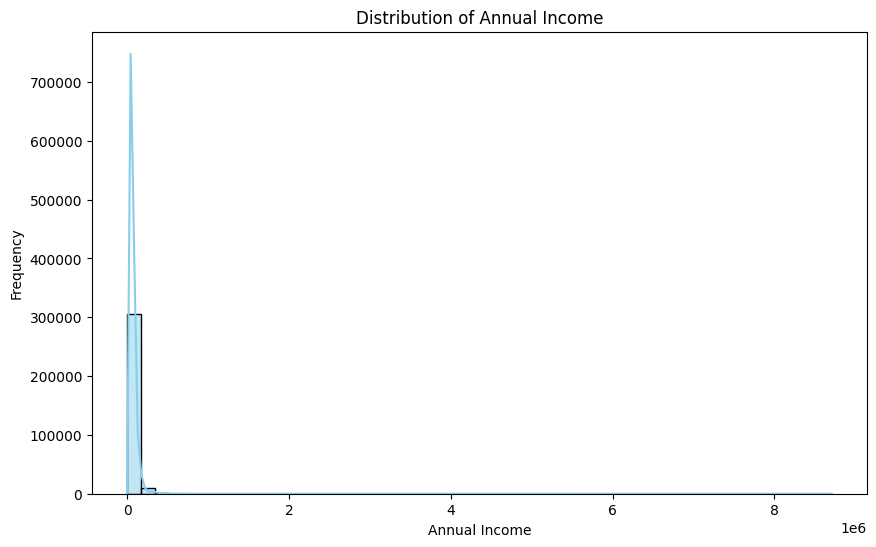

In [40]:
plt.figure(figsize=(10, 6))
sns.histplot(train_df['annual_inc'], kde=True, bins=50, color='skyblue')
plt.title('Distribution of Annual Income')
plt.xlabel('Annual Income')
plt.ylabel('Frequency')
plt.show()

<Axes: xlabel='loan_status', ylabel='annual_inc'>

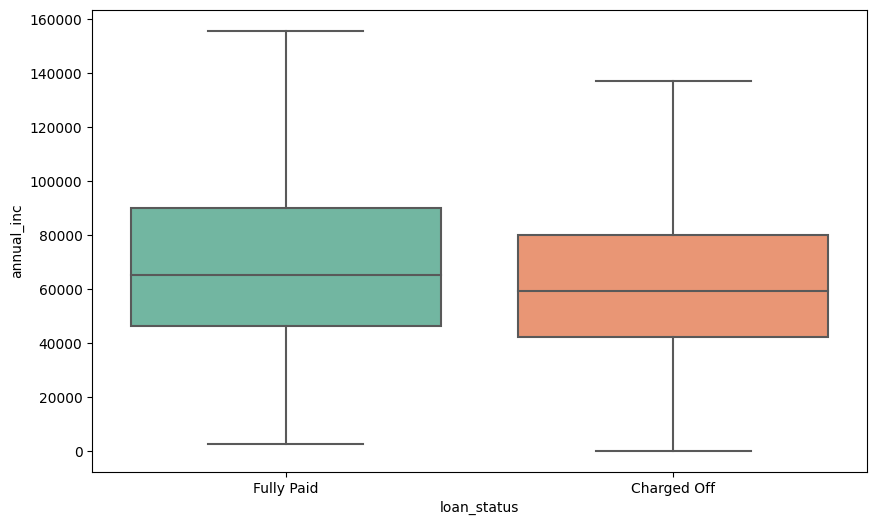

In [41]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='loan_status', y='annual_inc', data=train_df, palette='Set2', showfliers=False)

**Observations**
* The median annual income for Charged Off loans is lower than for Fully Paid loans.
* This suggests that borrowers with lower incomes are more likely to default.

**Loan Amount**

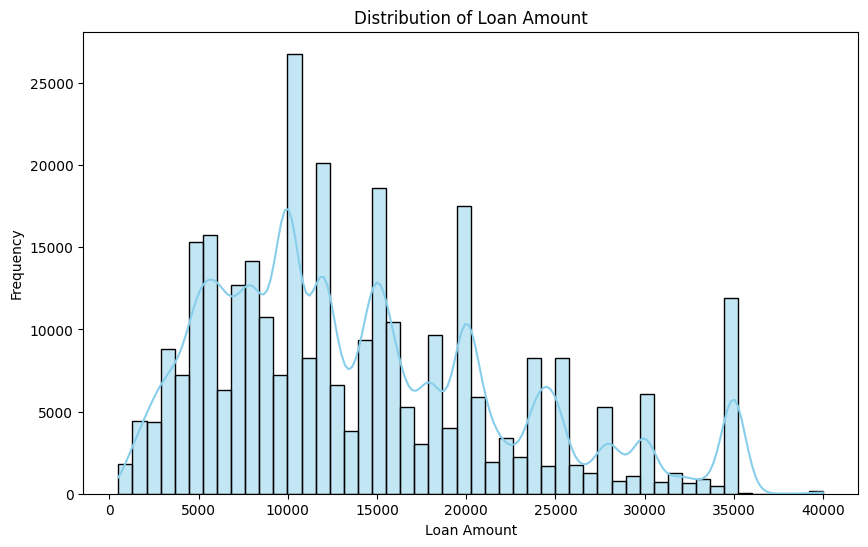

In [42]:
plt.figure(figsize=(10, 6))
sns.histplot(train_df['loan_amnt'], kde=True, bins=50, color='skyblue')
plt.title('Distribution of Loan Amount')
plt.xlabel('Loan Amount')
plt.ylabel('Frequency')
plt.show()

<Axes: xlabel='loan_status', ylabel='loan_amnt'>

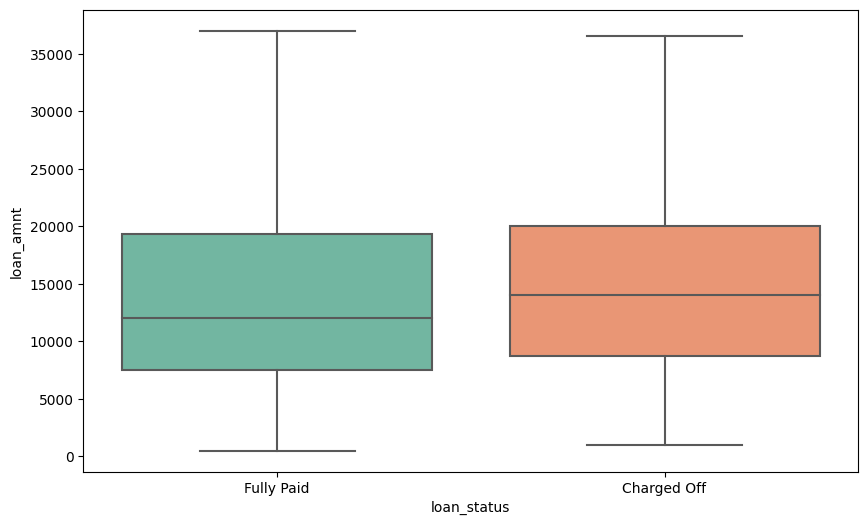

In [43]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='loan_status', y='loan_amnt', data=train_df, palette='Set2', showfliers=False)

**Observations**
* Since for both there is no significant difference, we can create an interactive feature at the later stage.

**Installment**

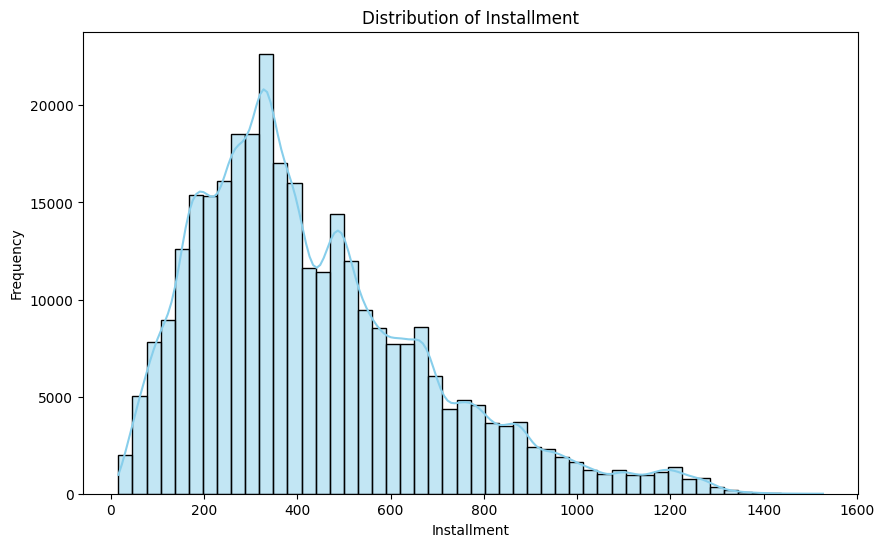

In [44]:
plt.figure(figsize=(10, 6))
sns.histplot(train_df['installment'], kde=True, bins=50, color='skyblue')
plt.title('Distribution of Installment')
plt.xlabel('Installment')
plt.ylabel('Frequency')
plt.show()

<Axes: xlabel='loan_status', ylabel='installment'>

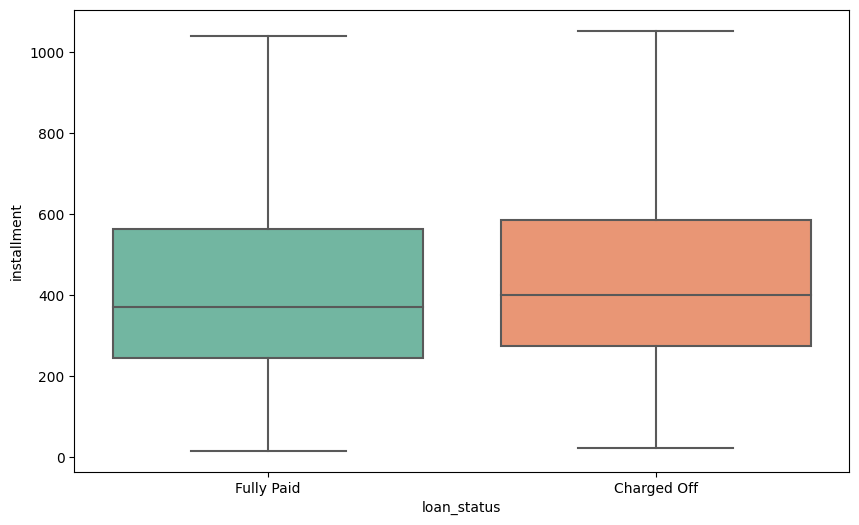

In [45]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='loan_status', y='installment', data=train_df, palette='Set2', showfliers=False)

**Observations**
* Since for both there is no significant difference, we can create an interactive feature at the later stage.

**Interest Rate**

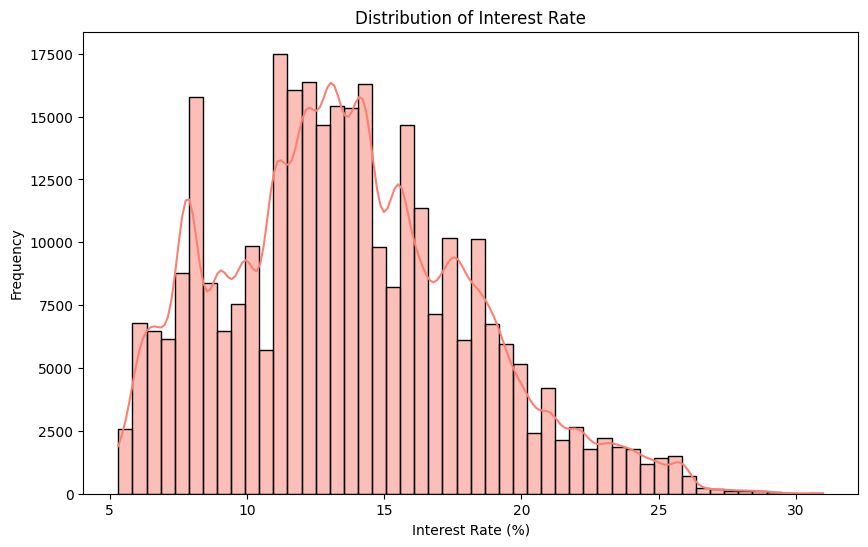

In [46]:
plt.figure(figsize=(10, 6))
sns.histplot(train_df['int_rate'], kde=True, bins=50, color='salmon')
plt.title('Distribution of Interest Rate')
plt.xlabel('Interest Rate (%)')
plt.ylabel('Frequency')
plt.show()

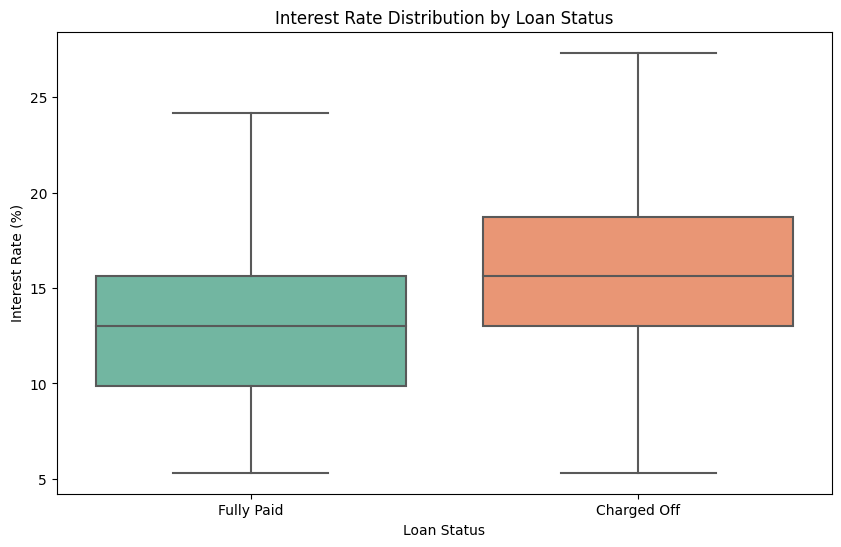

In [47]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='loan_status', y='int_rate', data=train_df, palette='Set2', showfliers=False)
plt.title('Interest Rate Distribution by Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('Interest Rate (%)')
plt.show()

**Observations**
* Charged Off loans have a higher median int_rate than Fully Paid loans.
* Higher interest rates signal riskier borrowers, making it a strong predictor

**Debt to income ratio (DTI)**

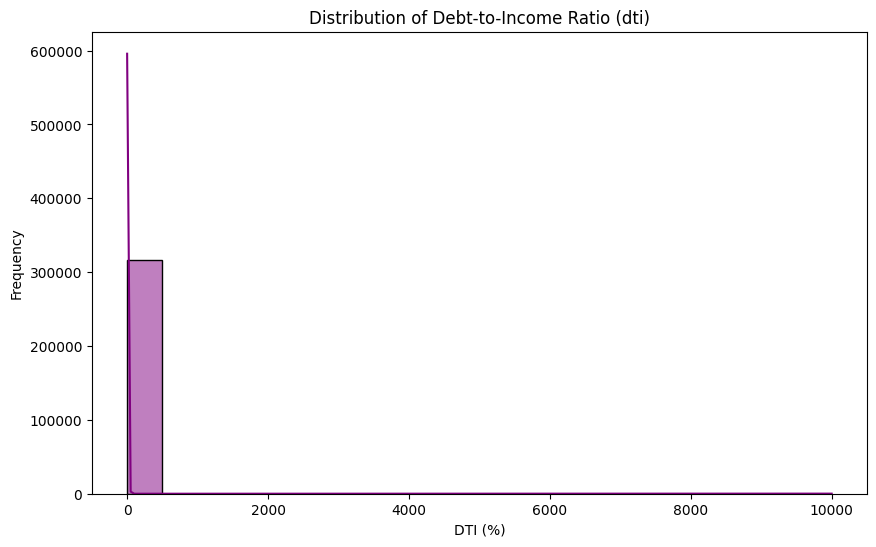

In [48]:
plt.figure(figsize=(10, 6))
sns.histplot(train_df['dti'], kde=True, bins=20, color='purple')
plt.title('Distribution of Debt-to-Income Ratio (dti)')
plt.xlabel('DTI (%)')
plt.ylabel('Frequency')
plt.show()

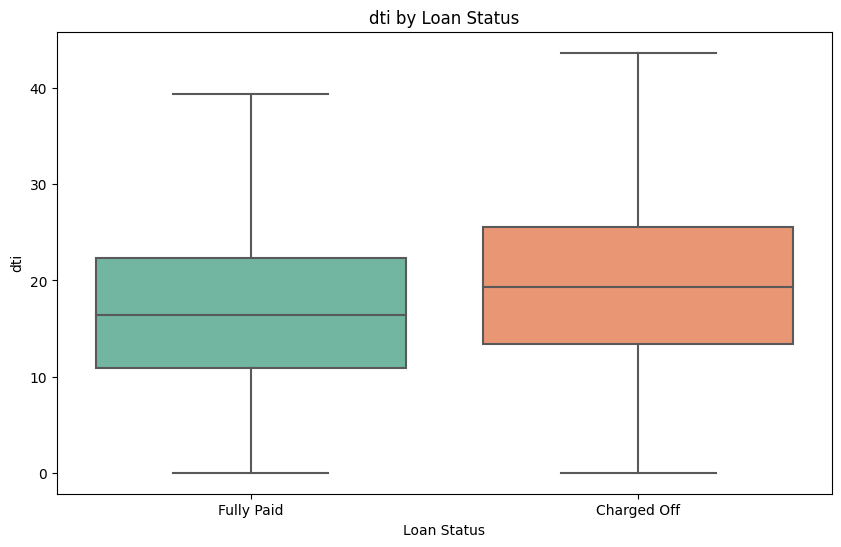

In [49]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='loan_status', y='dti', data=train_df, palette='Set2', showfliers=False)
plt.title('dti by Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('dti')
plt.show()

**Observations**
* The median debt-to-income ratio (dti) is higher for Charged Off loans than for Fully Paid loans.
* This suggests that borrowers with higher total debt burdens relative to income are more likely to default.

**Revolving Utilization**

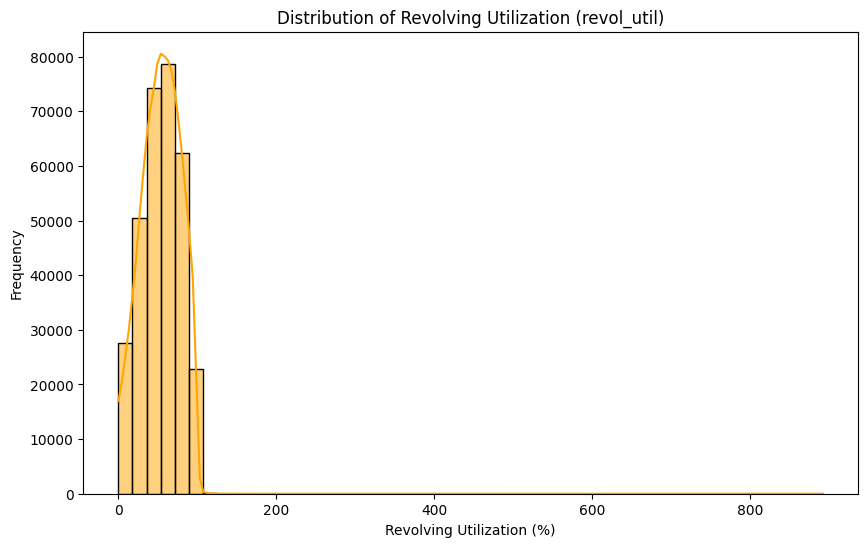

In [50]:
plt.figure(figsize=(10, 6))
sns.histplot(train_df['revol_util'].dropna(), kde=True, bins=50, color='orange')
plt.title('Distribution of Revolving Utilization (revol_util)')
plt.xlabel('Revolving Utilization (%)')
plt.ylabel('Frequency')
plt.show()

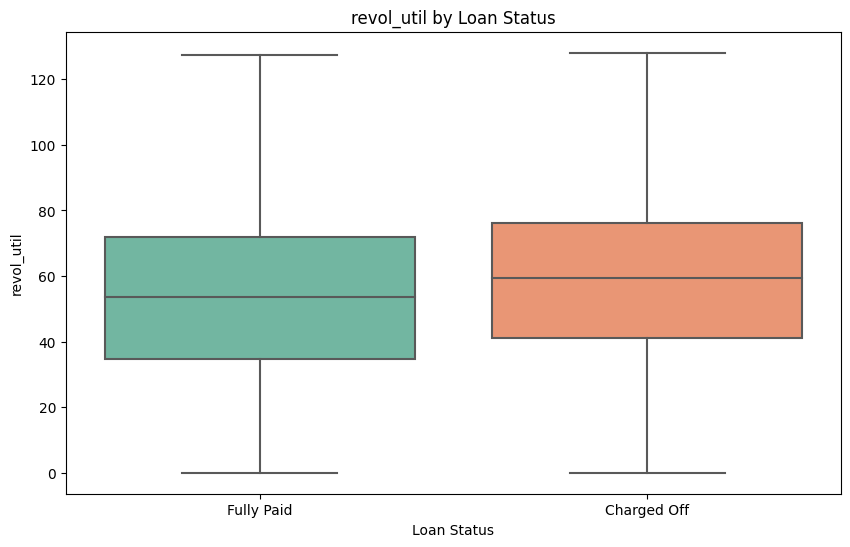

In [51]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='loan_status', y='revol_util', data=train_df, palette='Set2', showfliers=False)
plt.title('revol_util by Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('revol_util')
plt.show()

**Observations**
* The median revolving credit utilization (revol_util) is higher for Charged Off loans than for Fully Paid loans.
* This suggests that borrowers who use a higher percentage of their available revolving credit (credit cards, lines of credit) are more likely to default.

**Revolving Balance**

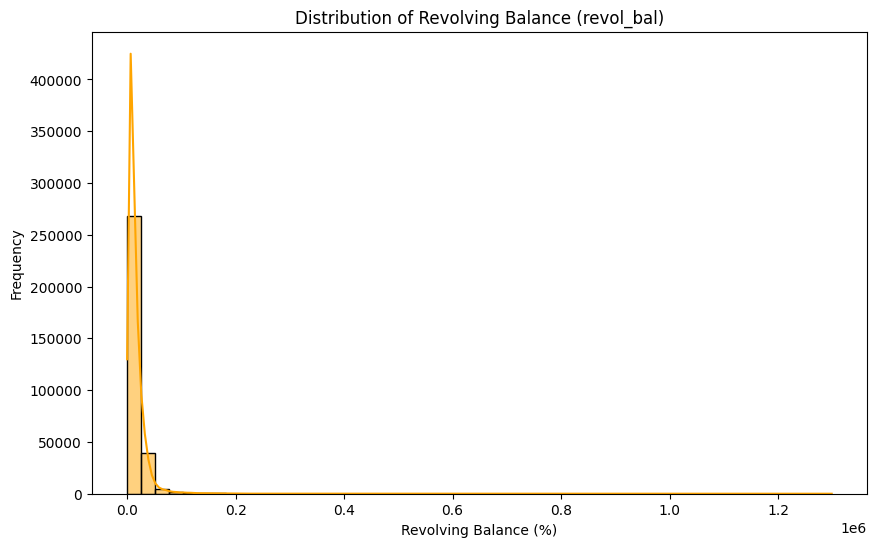

In [52]:
plt.figure(figsize=(10, 6))
sns.histplot(train_df['revol_bal'].dropna(), kde=True, bins=50, color='orange')
plt.title('Distribution of Revolving Balance (revol_bal)')
plt.xlabel('Revolving Balance (%)')
plt.ylabel('Frequency')
plt.show()

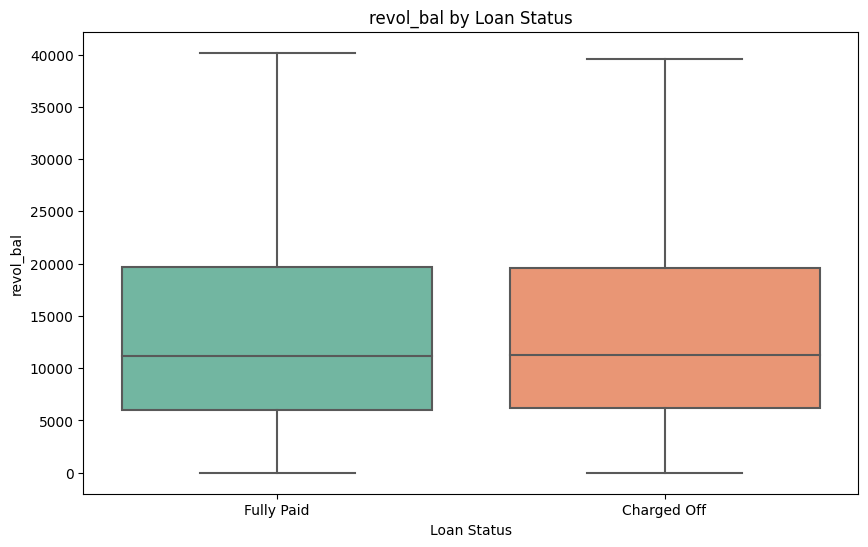

In [53]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='loan_status', y='revol_bal', data=train_df, palette='Set2', showfliers=False)
plt.title('revol_bal by Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('revol_bal')
plt.show()

In [54]:
train_df.drop(['revol_bal'],axis=1,inplace=True)
train_df.shape

(316327, 25)

**Observations**
* No significant difference between both that helps us to differentiate the two classes.
* Hence we are dropping this feature.

**Total Accounts & Open Accounts**

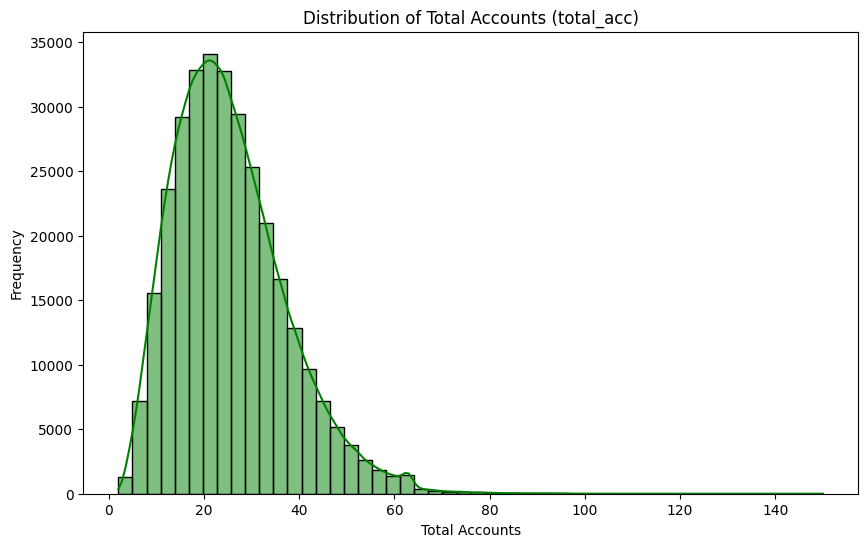

In [55]:
plt.figure(figsize=(10, 6))
sns.histplot(train_df['total_acc'], kde=True, bins=50, color='green')
plt.title('Distribution of Total Accounts (total_acc)')
plt.xlabel('Total Accounts')
plt.ylabel('Frequency')
plt.show()

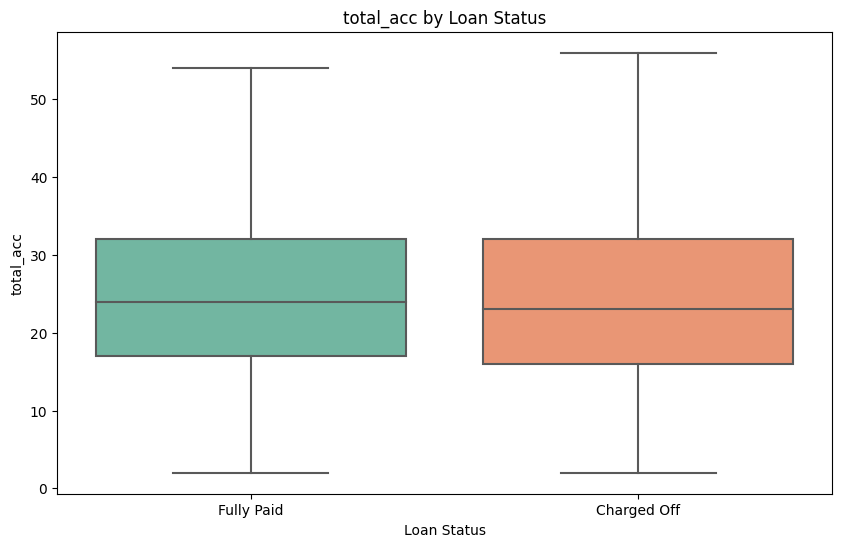

In [56]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='loan_status', y='total_acc', data=train_df, palette='Set2', showfliers=False)
plt.title('total_acc by Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('total_acc')
plt.show()

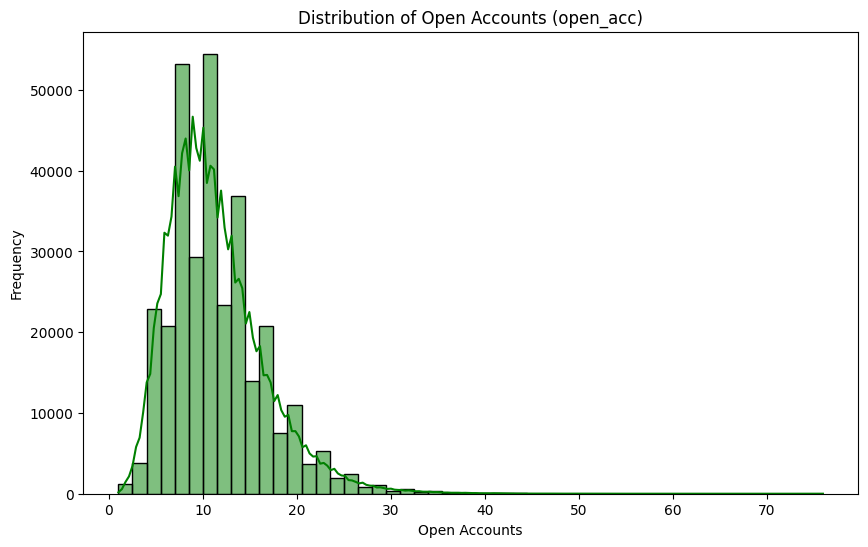

In [57]:
plt.figure(figsize=(10, 6))
sns.histplot(train_df['open_acc'], kde=True, bins=50, color='green')
plt.title('Distribution of Open Accounts (open_acc)')
plt.xlabel('Open Accounts')
plt.ylabel('Frequency')
plt.show()

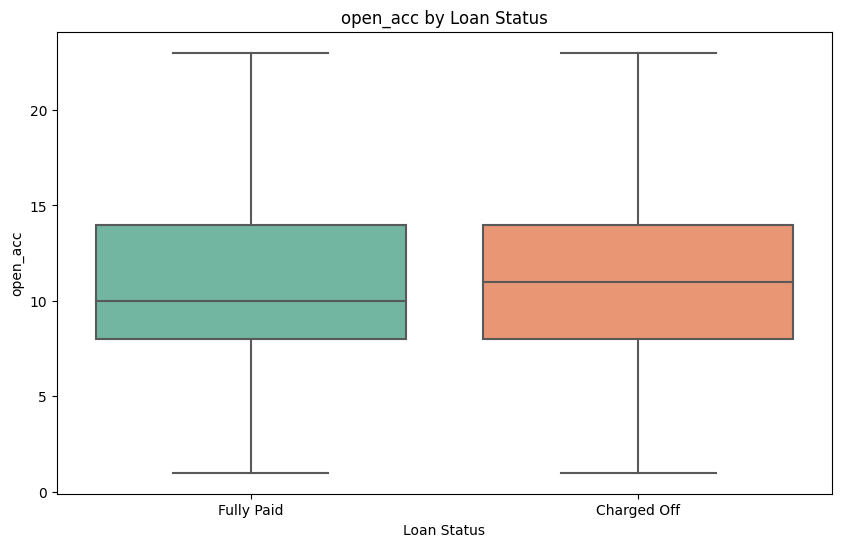

In [58]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='loan_status', y='open_acc', data=train_df, palette='Set2', showfliers=False)
plt.title('open_acc by Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('open_acc')
plt.show()

**Earliest Credit Line**

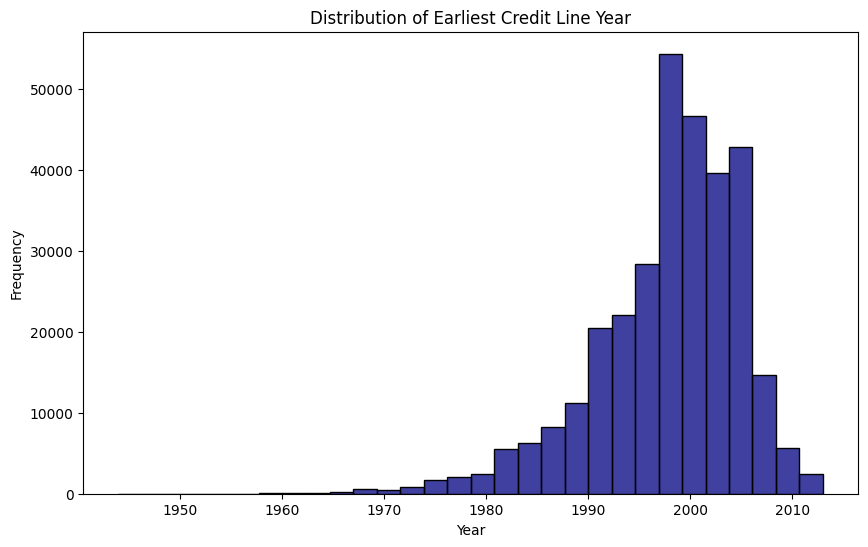

In [59]:
train_df['earliest_cr_line'] = pd.to_datetime(train_df['earliest_cr_line'], errors='coerce')

plt.figure(figsize=(10, 6))
sns.histplot(train_df['earliest_cr_line'].dt.year.dropna(), bins=30, color='navy')
plt.title('Distribution of Earliest Credit Line Year')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()

**Home Ownership**

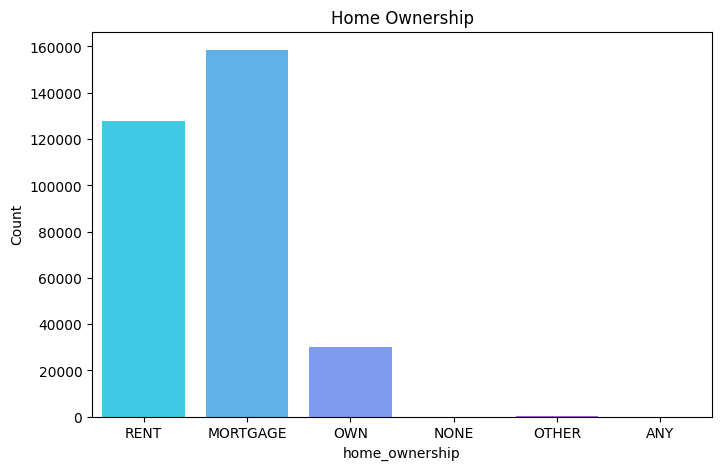

In [60]:
plt.figure(figsize=(8, 5))
sns.countplot(x='home_ownership', data=train_df, palette='cool')
plt.title('Home Ownership')
plt.ylabel('Count')
plt.show()

**Grade & Subgrade**

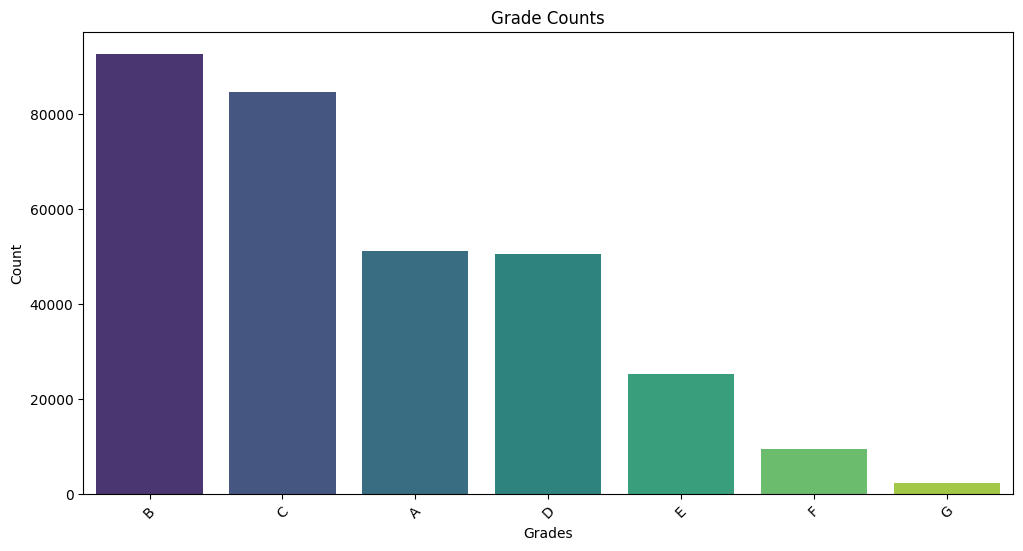

In [61]:
grade_count = train_df['grade'].value_counts()
plt.figure(figsize=(12, 6))
sns.barplot(x=grade_count.index, y=grade_count.values, palette='viridis')
plt.title('Grade Counts')
plt.xlabel('Grades')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

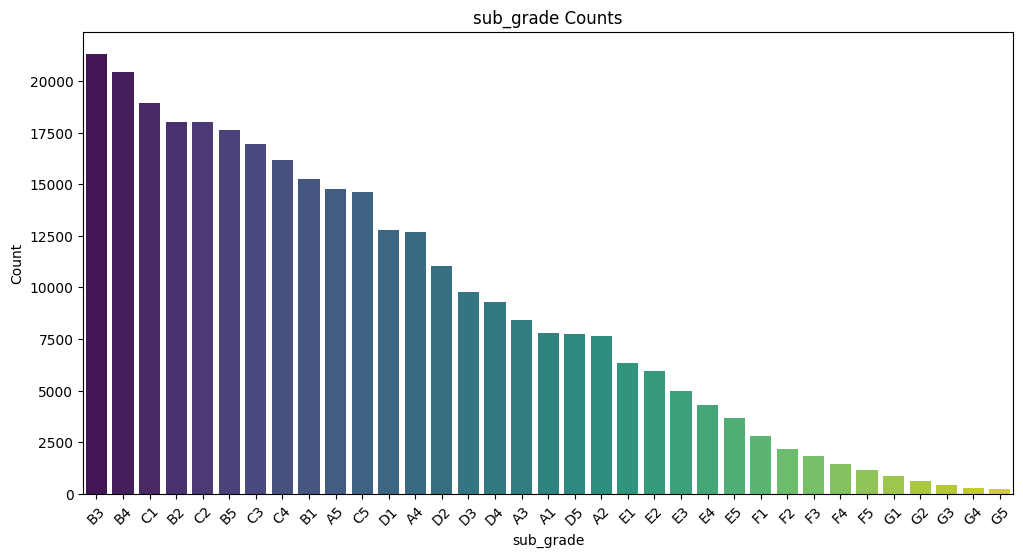

In [62]:
grade_count = train_df['sub_grade'].value_counts()
plt.figure(figsize=(12, 6))
sns.barplot(x=grade_count.index, y=grade_count.values, palette='viridis')
plt.title('sub_grade Counts')
plt.xlabel('sub_grade')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [63]:
train_df.drop(['sub_grade'],inplace=True,axis=1)
train_df.shape

(316327, 24)

**Observations**
* We will use Grade as sub_grade and grade represent the same thing.
* Also grade has lesser categories compared to sub_grade.

**Loan Purpose**

In [64]:
train_df['purpose'].value_counts()

purpose
debt_consolidation    187510
credit_card            66498
home_improvement       19149
other                  16836
major_purchase          6939
small_business          4534
car                     3741
medical                 3334
moving                  2242
vacation                1925
house                   1771
wedding                 1398
renewable_energy         251
educational              199
Name: count, dtype: int64

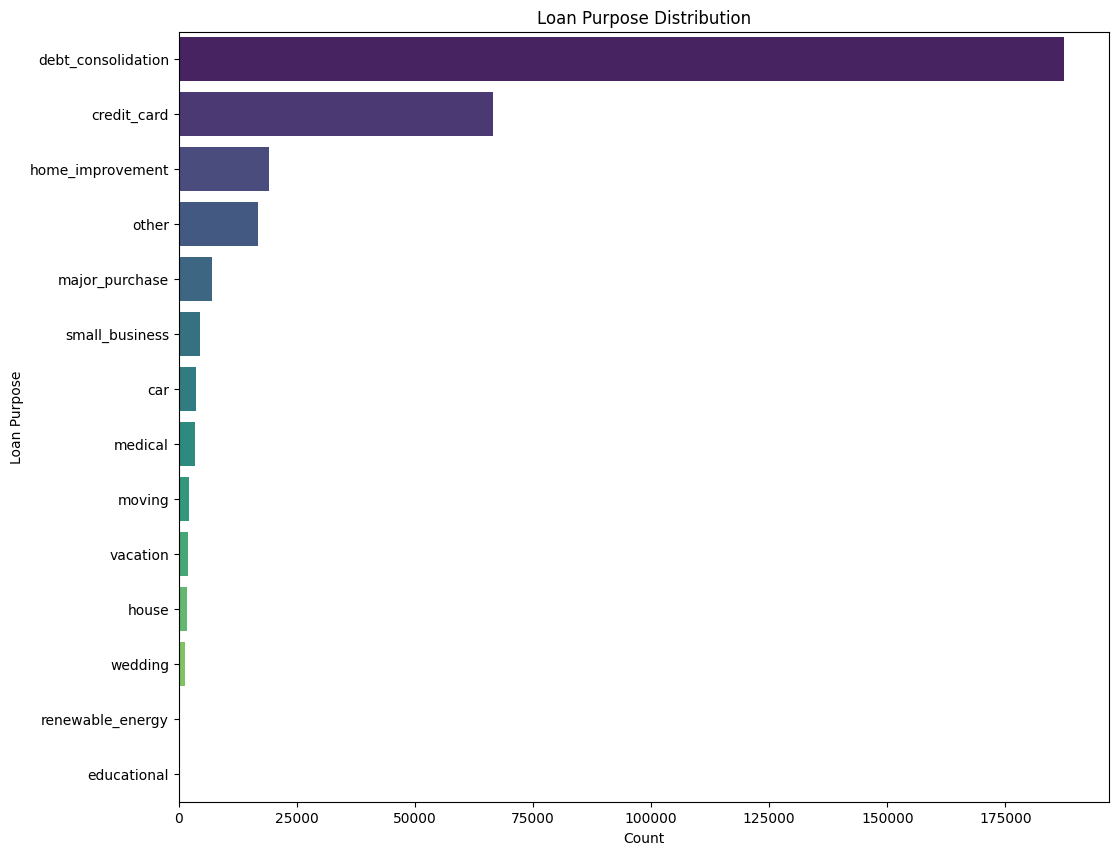

In [65]:
plt.figure(figsize=(12, 10))
sns.countplot(y='purpose', data=train_df, order=train_df['purpose'].value_counts().index, palette='viridis')
plt.title('Loan Purpose Distribution')
plt.xlabel('Count')
plt.ylabel('Loan Purpose')
plt.show()

**Application Type**

In [66]:
train_df['application_type'].value_counts()

application_type
INDIVIDUAL    315748
JOINT            349
DIRECT_PAY       230
Name: count, dtype: int64

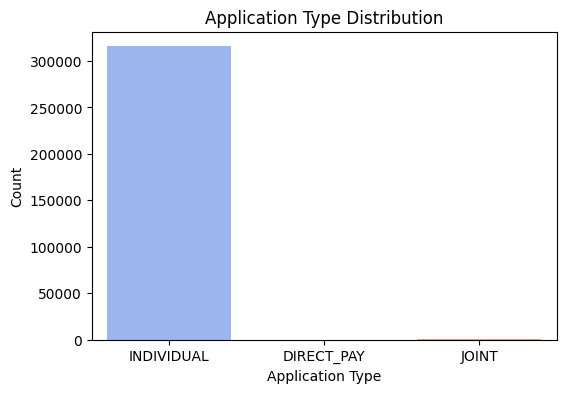

In [67]:
plt.figure(figsize=(6, 4))
sns.countplot(x='application_type', data=train_df, palette='coolwarm')
plt.title('Application Type Distribution')
plt.xlabel('Application Type')
plt.ylabel('Count')
plt.show()

In [68]:
train_df.drop(['application_type'],axis=1,inplace=True)
train_df.shape

(316327, 23)

**Observations**
* Since it has single category as majority >99 %, it wont be useful.
* Hence we are dropping this feature.

**Verification Status**

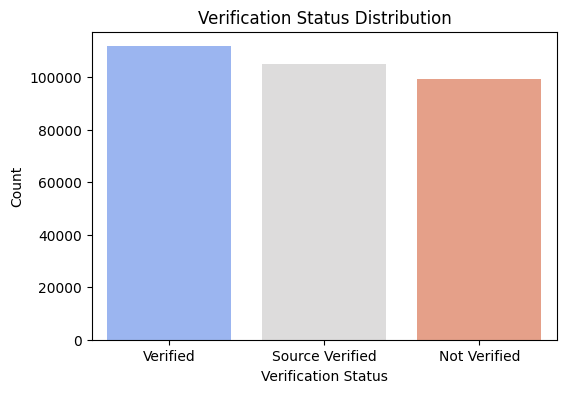

In [69]:
plt.figure(figsize=(6, 4))
sns.countplot(x='verification_status', data=train_df, palette='coolwarm')
plt.title('Verification Status Distribution')
plt.xlabel('Verification Status')
plt.ylabel('Count')
plt.show()

**Term**

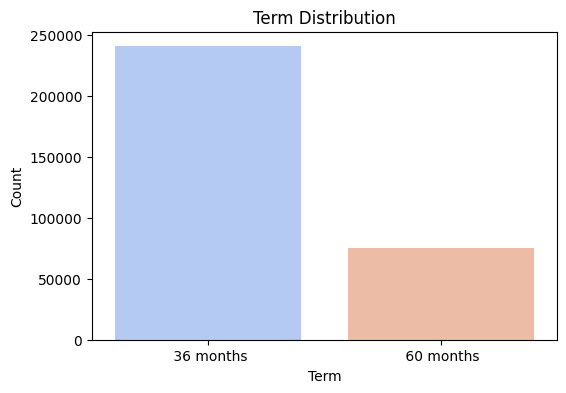

In [70]:
plt.figure(figsize=(6, 4))
sns.countplot(x='term', data=train_df, palette='coolwarm')
plt.title('Term Distribution')
plt.xlabel('Term')
plt.ylabel('Count')
plt.show()

**Public Derogatory Records**

In [71]:
len(train_df['pub_rec'].unique())

17

In [72]:
train_df['pub_rec'].value_counts()

pub_rec
0.0     270021
1.0      39861
2.0       4399
3.0       1208
4.0        434
5.0        190
6.0        104
7.0         48
8.0         27
9.0         11
10.0         9
11.0         7
13.0         3
12.0         2
15.0         1
40.0         1
86.0         1
Name: count, dtype: int64

In [73]:
train_df['pub_rec'] = train_df['pub_rec'].apply(
    lambda x: '0' if x == 0 else ('1' if x == 1 else '2+')
)

train_df['pub_rec'].value_counts()

pub_rec
0     270021
1      39861
2+      6445
Name: count, dtype: int64

**Public Record for Bankruptcies**

In [74]:
train_df['pub_rec_bankruptcies'].value_counts()

pub_rec_bankruptcies
0.0    280170
1.0     34284
2.0      1478
3.0       290
4.0        70
5.0        24
6.0         5
7.0         4
8.0         2
Name: count, dtype: int64

In [75]:
train_df['pub_rec_bankruptcies'] = train_df['pub_rec_bankruptcies'].apply(
    lambda x: '0' if x == 0 else ('1' if x == 1 else '2+')
)

train_df['pub_rec_bankruptcies'].value_counts()

pub_rec_bankruptcies
0     280170
1      34284
2+      1873
Name: count, dtype: int64

**Initial Loan List Status**

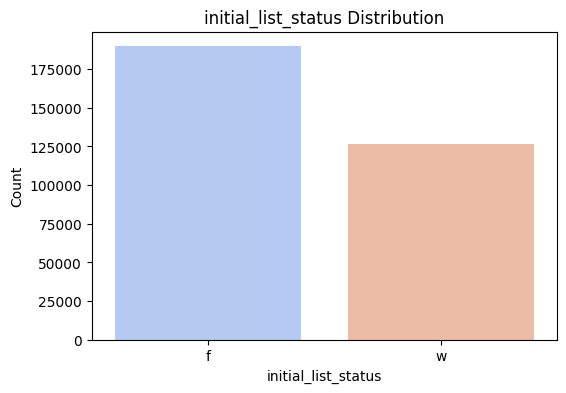

In [76]:
plt.figure(figsize=(6, 4))
sns.countplot(x='initial_list_status', data=train_df, palette='coolwarm')
plt.title('initial_list_status Distribution')
plt.xlabel('initial_list_status')
plt.ylabel('Count')
plt.show()

# Target Feature EDA

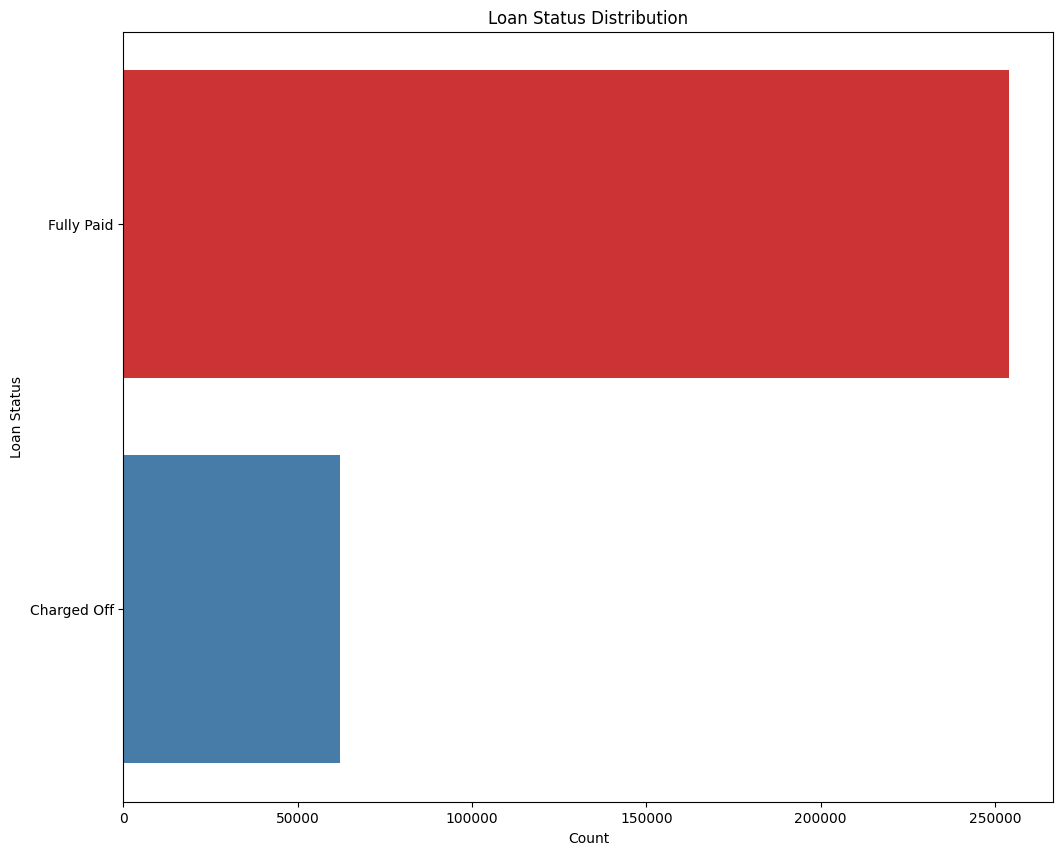

In [77]:
plt.figure(figsize=(12, 10))
sns.countplot(y='loan_status', data=train_df, palette='Set1')
plt.title('Loan Status Distribution')
plt.xlabel('Count')
plt.ylabel('Loan Status')
plt.show()

In [78]:
train_df['loan_status'].value_counts(normalize=True)

loan_status
Fully Paid     0.803292
Charged Off    0.196708
Name: proportion, dtype: float64

# Dropping unwanted features

In [79]:
train_df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'purpose', 'dti', 'earliest_cr_line', 'open_acc',
       'pub_rec', 'revol_util', 'total_acc', 'initial_list_status', 'mort_acc',
       'pub_rec_bankruptcies', 'address', 'mort_acc_missing'],
      dtype='object')

In [80]:
train_df.shape

(316327, 23)

In [81]:
train_df.drop(['address','issue_d','mort_acc_missing'],axis=1,inplace=True)
train_df.shape

(316327, 20)

In [82]:
train_df.isnull().sum()

loan_amnt               0
term                    0
int_rate                0
installment             0
grade                   0
emp_length              0
home_ownership          0
annual_inc              0
verification_status     0
loan_status             0
purpose                 0
dti                     0
earliest_cr_line        0
open_acc                0
pub_rec                 0
revol_util              0
total_acc               0
initial_list_status     0
mort_acc                0
pub_rec_bankruptcies    0
dtype: int64

# Feature Engineering & Exploratory Data Analysis

**Loan to Income Ratio**

In [83]:
zero_income_count = (train_df['annual_inc'] == 0).sum()
print(f"Number of borrowers with zero income: {zero_income_count}")

Number of borrowers with zero income: 1


In [84]:
train_df = train_df[train_df['annual_inc'] > 0]

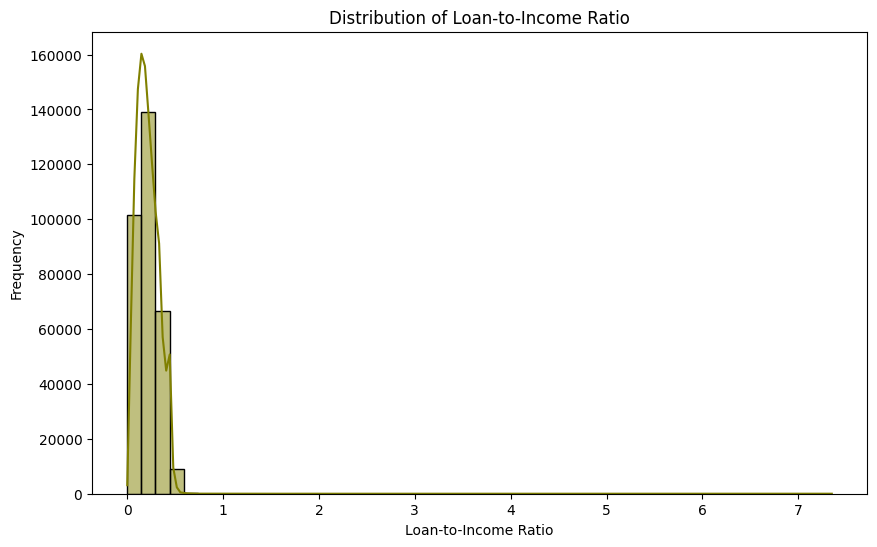

In [85]:
train_df['loan_to_income'] = train_df['loan_amnt'] / train_df['annual_inc']

plt.figure(figsize=(10, 6))
sns.histplot(train_df['loan_to_income'], kde=True, bins=50, color='olive')
plt.title('Distribution of Loan-to-Income Ratio')
plt.xlabel('Loan-to-Income Ratio')
plt.ylabel('Frequency')
plt.show()

<Axes: xlabel='loan_status', ylabel='loan_to_income'>

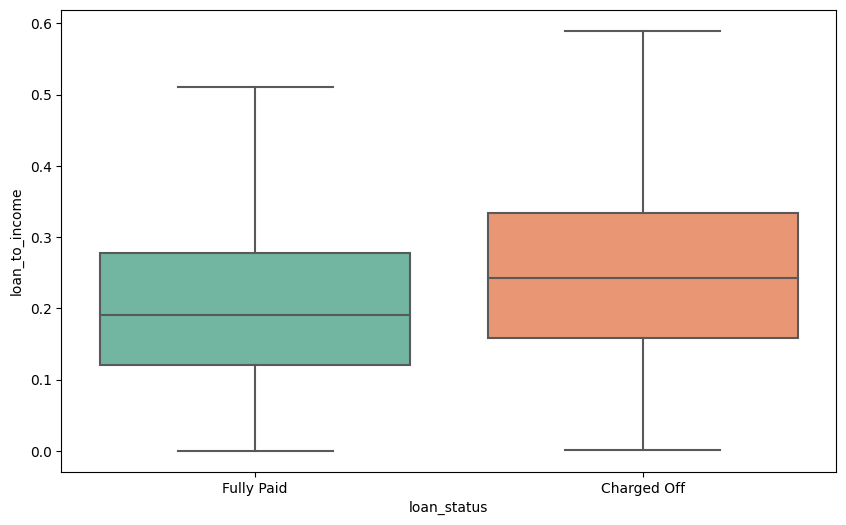

In [86]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='loan_status', y='loan_to_income', data=train_df, palette='Set2', showfliers=False)

**Observations**
* The median Loan-to-Income Ratio appears slightly higher for Charged Off loans than for Fully Paid loans.
* This suggests that borrowers with a higher debt burden relative to income might be more likely to default.
* There’s more variability in the loan-to-income ratio among people who default based on the wider IQR range.

In [87]:
skewness = train_df['loan_to_income'].skew()
print(f"Skewness of Loan-to-Income Ratio: {skewness:.4f}")

Skewness of Loan-to-Income Ratio: 1.4056


**Total Interest Owed**

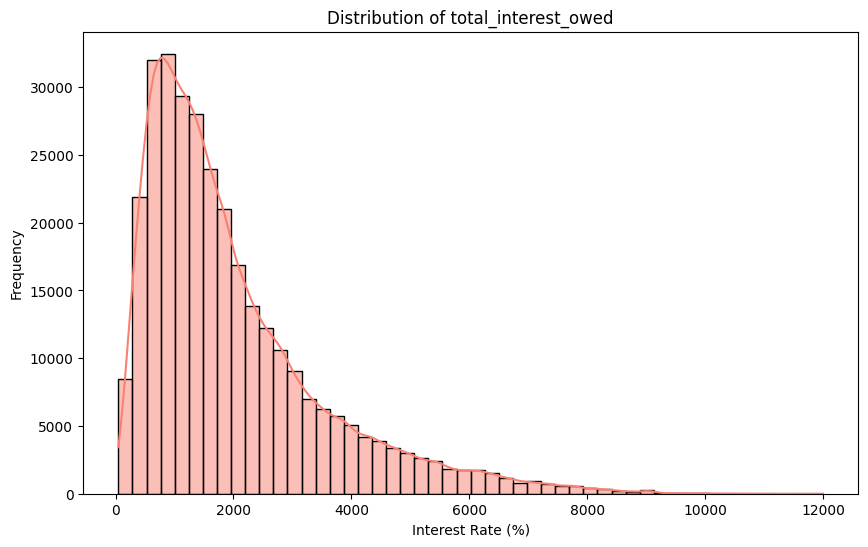

In [88]:
train_df['total_interest_owed'] = train_df['loan_amnt'] * (train_df['int_rate'] / 100)

plt.figure(figsize=(10, 6))
sns.histplot(train_df['total_interest_owed'], kde=True, bins=50, color='salmon')
plt.title('Distribution of total_interest_owed')
plt.xlabel('Interest Rate (%)')
plt.ylabel('Frequency')
plt.show()

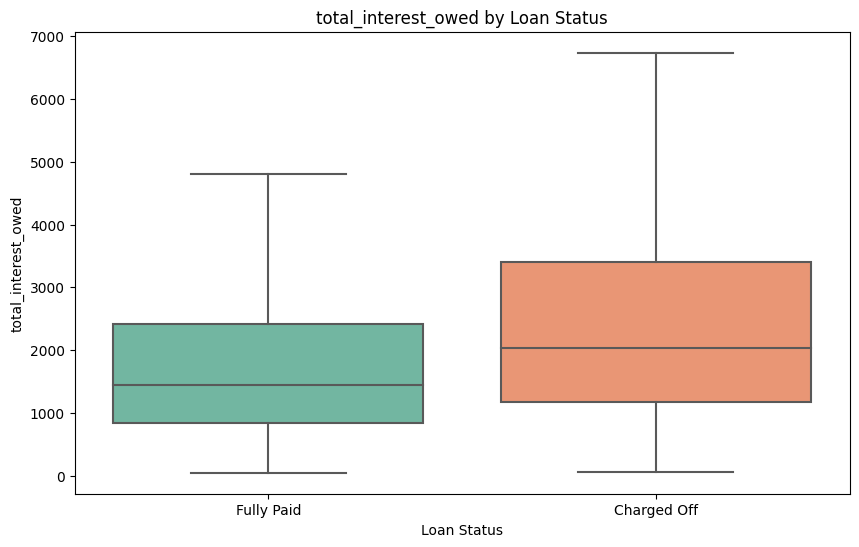

In [89]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='loan_status', y='total_interest_owed', data=train_df, palette='Set2', showfliers=False)
plt.title('total_interest_owed by Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('total_interest_owed')
plt.show()

**Observations**
* The median interest owed is noticeably higher for Charged Off loans than for Fully Paid loans.
* This suggests that borrowers who default tend to owe more in interest, possibly due to higher loan amounts, longer loan terms, or higher interest rates.

**Installment to Income Ratio**

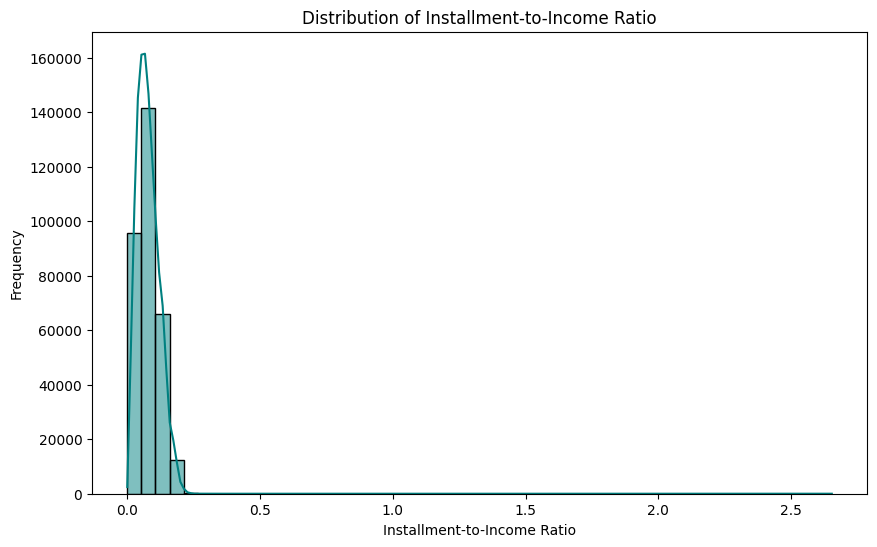

In [90]:
train_df['installment_to_income_ratio'] = train_df['installment'] / (train_df['annual_inc'] / 12)

plt.figure(figsize=(10, 6))
sns.histplot(train_df['installment_to_income_ratio'], kde=True, bins=50, color='teal')
plt.title('Distribution of Installment-to-Income Ratio')
plt.xlabel('Installment-to-Income Ratio')
plt.ylabel('Frequency')
plt.show()

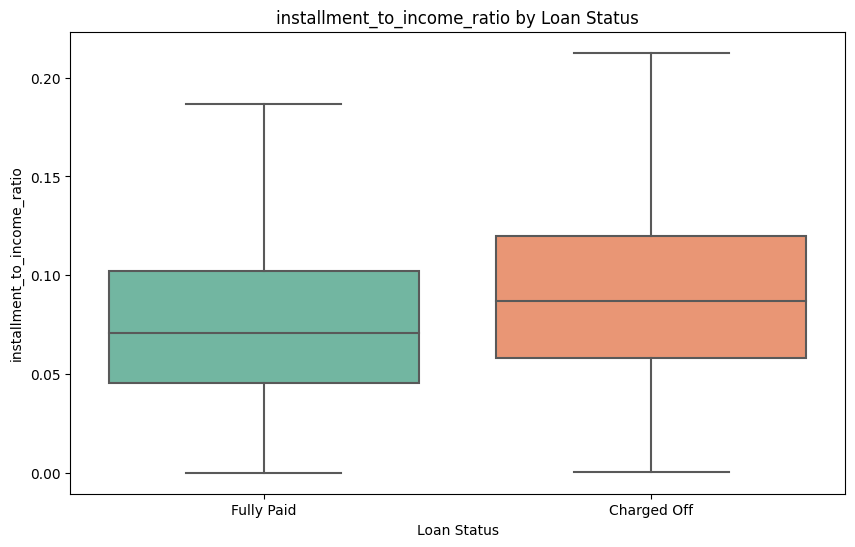

In [91]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='loan_status', y='installment_to_income_ratio', data=train_df, palette='Set2', showfliers=False)
plt.title('installment_to_income_ratio by Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('installment_to_income_ratio')
plt.show()

**Observations**
* The median installment-to-income ratio is higher for Charged Off loans than for Fully Paid loans.
* This suggests that borrowers who allocate a higher percentage of their income toward loan installments are more likely to default.

**Active Accounts Percentage**

In [92]:
train_df['active_credit_pct'] = train_df.apply(lambda row: row['open_acc'] / row['total_acc']
                                                 if row['total_acc'] > 0 else np.nan, axis=1)

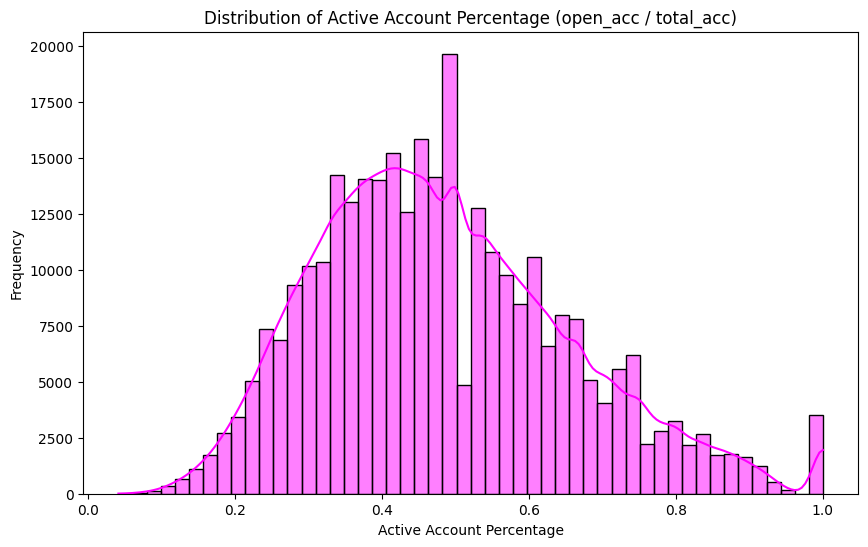

In [93]:
plt.figure(figsize=(10, 6))
sns.histplot(train_df['active_credit_pct'], kde=True, bins=50, color='magenta')
plt.title('Distribution of Active Account Percentage (open_acc / total_acc)')
plt.xlabel('Active Account Percentage')
plt.ylabel('Frequency')
plt.show()

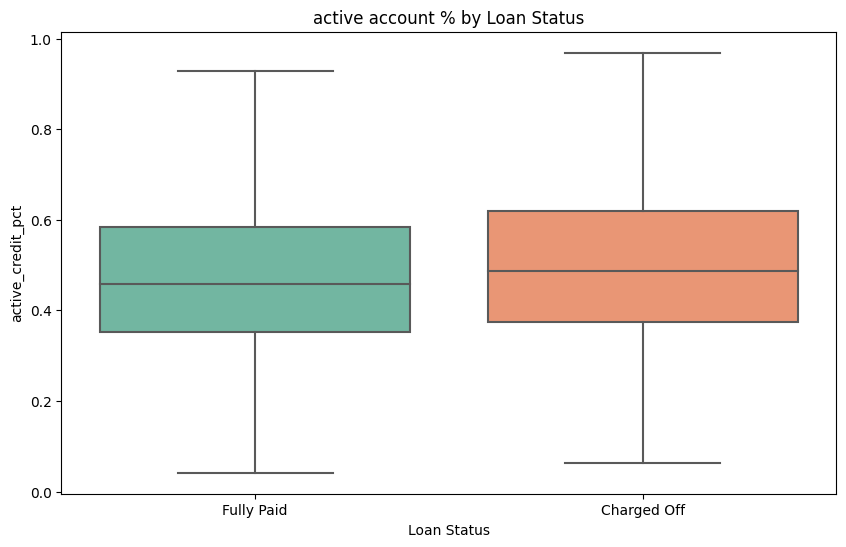

In [94]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='loan_status', y='active_credit_pct', data=train_df, palette='Set2', showfliers=False)
plt.title('active account % by Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('active_credit_pct')
plt.show()

**Observations**
* The median active account percentage is slightly higher for Charged Off loans than Fully Paid loans.
* This suggests that borrowers with a higher proportion of open accounts relative to their total accounts may have a slightly higher risk of default.

**Credit History**

In [95]:
current_year = pd.Timestamp('now').year
train_df['credit_age'] = current_year - train_df['earliest_cr_line'].dt.year

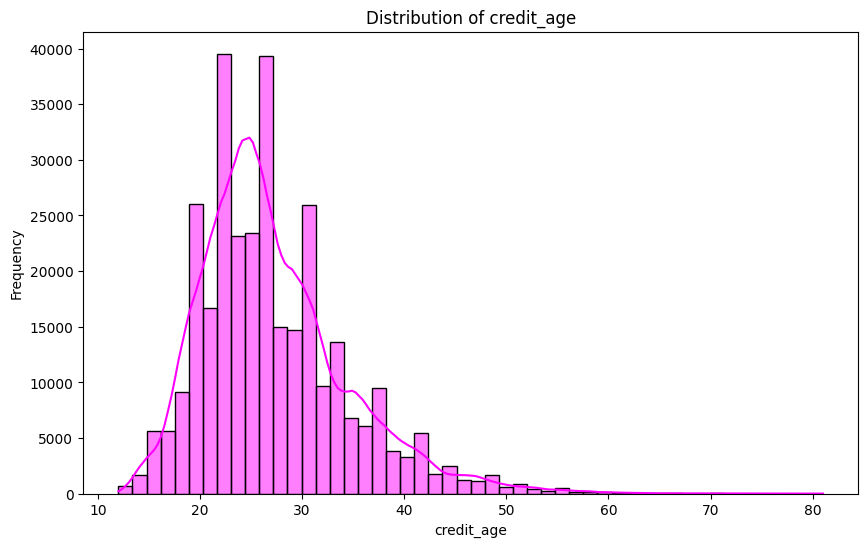

In [96]:
plt.figure(figsize=(10, 6))
sns.histplot(train_df['credit_age'], kde=True, bins=50, color='magenta')
plt.title('Distribution of credit_age')
plt.xlabel('credit_age')
plt.ylabel('Frequency')
plt.show()

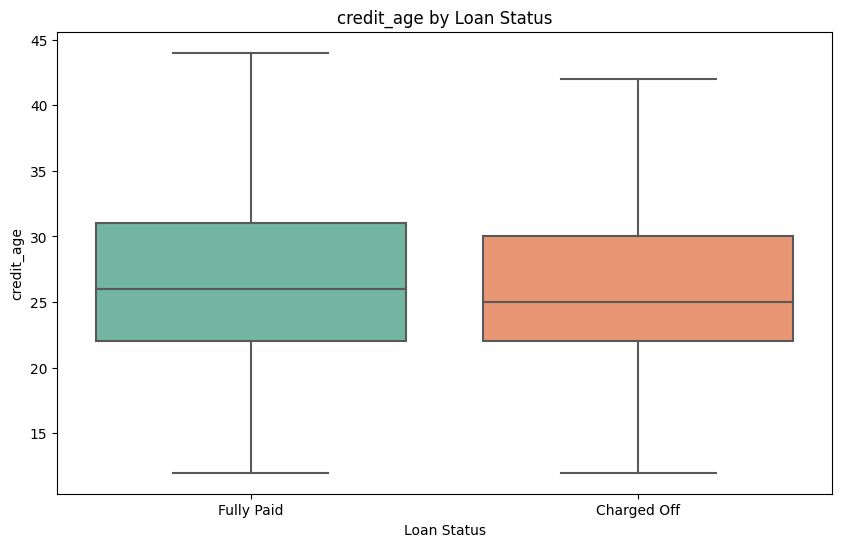

In [97]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='loan_status', y='credit_age', data=train_df, palette='Set2', showfliers=False)
plt.title('credit_age by Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('credit_age')
plt.show()

**Observations**
* The median credit age is slightly higher for Fully Paid loans compared to Charged Off loans.
* This aligns with industry expectations—borrowers with longer credit histories tend to be more financially stable and less likely to default.

# Feature Selection

In [98]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 316326 entries, 0 to 316969
Data columns (total 25 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   loan_amnt                    316326 non-null  float64       
 1   term                         316326 non-null  object        
 2   int_rate                     316326 non-null  float64       
 3   installment                  316326 non-null  float64       
 4   grade                        316326 non-null  object        
 5   emp_length                   316326 non-null  object        
 6   home_ownership               316326 non-null  object        
 7   annual_inc                   316326 non-null  float64       
 8   verification_status          316326 non-null  object        
 9   loan_status                  316326 non-null  object        
 10  purpose                      316326 non-null  object        
 11  dti                          31

In [99]:
train_df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'loan_status',
       'purpose', 'dti', 'earliest_cr_line', 'open_acc', 'pub_rec',
       'revol_util', 'total_acc', 'initial_list_status', 'mort_acc',
       'pub_rec_bankruptcies', 'loan_to_income', 'total_interest_owed',
       'installment_to_income_ratio', 'active_credit_pct', 'credit_age'],
      dtype='object')

In [100]:
features= ['term', 'int_rate', 'grade', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status',
       'purpose', 'dti', 'pub_rec',
       'revol_util', 'initial_list_status', 'mort_acc',
       'pub_rec_bankruptcies', 'loan_to_income', 'total_interest_owed',
       'installment_to_income_ratio', 'active_credit_pct', 'credit_age', 'loan_status']

final_df=train_df[features].copy()
final_df.shape

(316326, 20)

In [101]:
final_df_copy=final_df.copy()

In [102]:
final_df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 316326 entries, 0 to 316969
Data columns (total 20 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   term                         316326 non-null  object 
 1   int_rate                     316326 non-null  float64
 2   grade                        316326 non-null  object 
 3   emp_length                   316326 non-null  object 
 4   home_ownership               316326 non-null  object 
 5   annual_inc                   316326 non-null  float64
 6   verification_status          316326 non-null  object 
 7   purpose                      316326 non-null  object 
 8   dti                          316326 non-null  float64
 9   pub_rec                      316326 non-null  object 
 10  revol_util                   316326 non-null  float64
 11  initial_list_status          316326 non-null  object 
 12  mort_acc                     316326 non-null  float64
 13  pub_

In [103]:
cols = list(final_df_copy.columns)

le = LabelEncoder()

for col in cols:
    if final_df_copy[col].dtype == 'object':
        final_df_copy[col] = final_df_copy[col].astype(str)
        final_df_copy[col] = le.fit_transform(final_df_copy[col])

final_df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 316326 entries, 0 to 316969
Data columns (total 20 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   term                         316326 non-null  int64  
 1   int_rate                     316326 non-null  float64
 2   grade                        316326 non-null  int64  
 3   emp_length                   316326 non-null  int64  
 4   home_ownership               316326 non-null  int64  
 5   annual_inc                   316326 non-null  float64
 6   verification_status          316326 non-null  int64  
 7   purpose                      316326 non-null  int64  
 8   dti                          316326 non-null  float64
 9   pub_rec                      316326 non-null  int64  
 10  revol_util                   316326 non-null  float64
 11  initial_list_status          316326 non-null  int64  
 12  mort_acc                     316326 non-null  float64
 13  pub_

<Axes: >

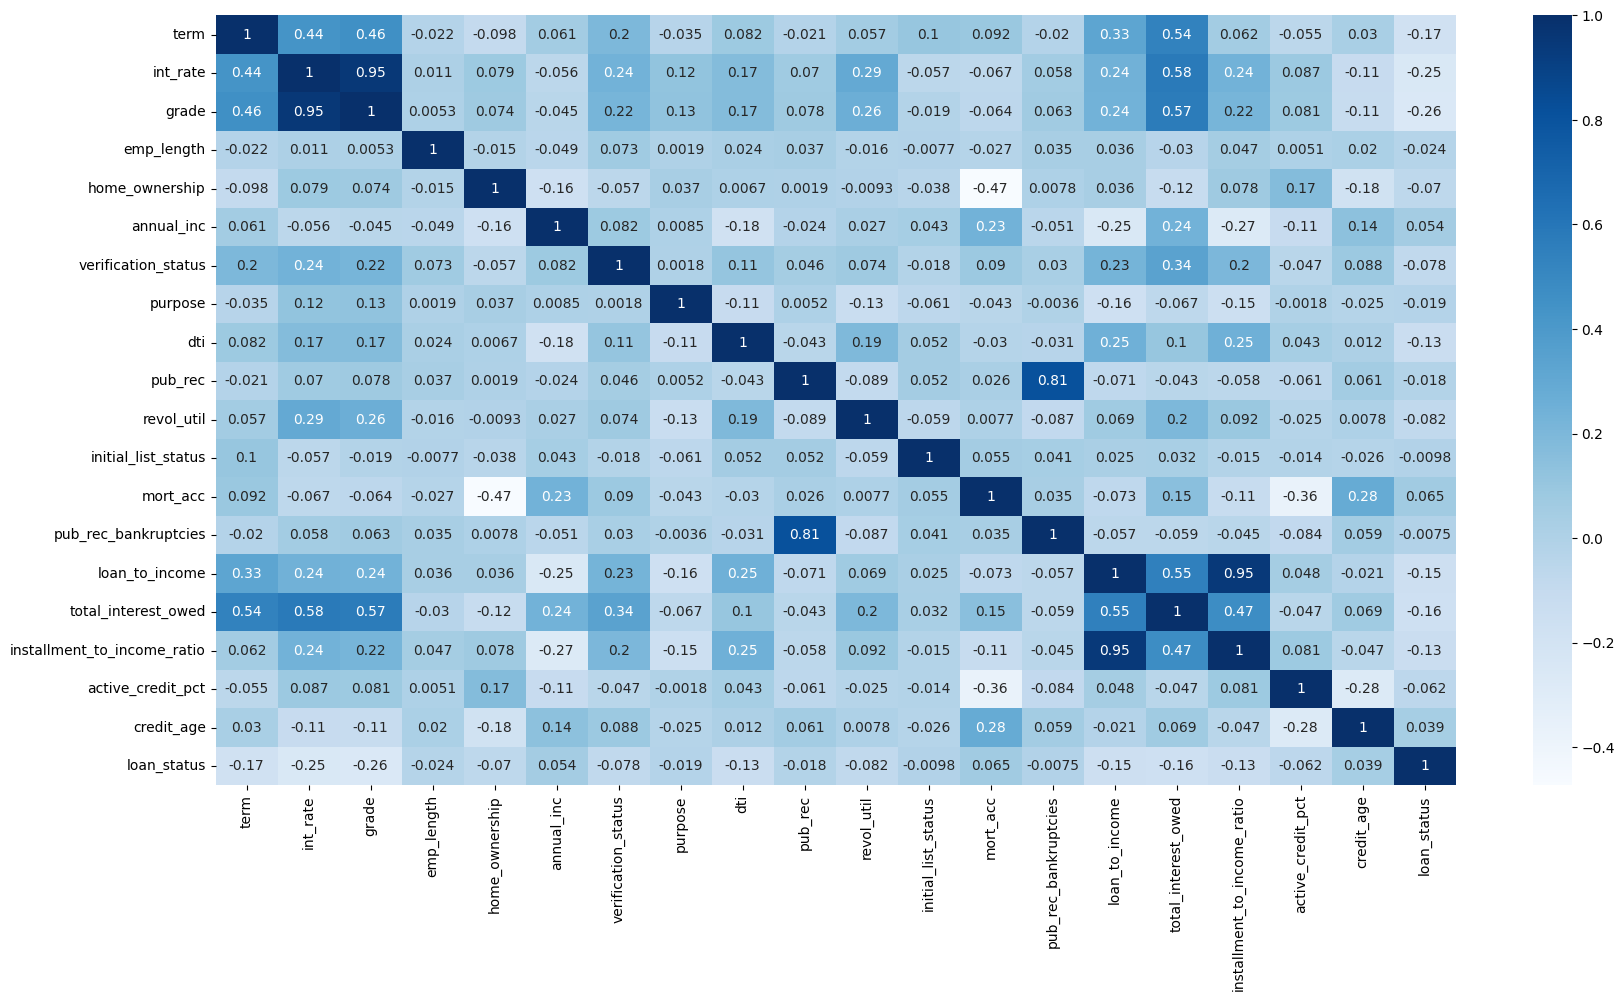

In [104]:
plt.figure(figsize=(20,10))
sns.heatmap(final_df_copy.corr(),annot=True,cmap='Blues')

# Model Building using LightGBM Classifier

In [105]:
model_df = final_df.copy()
model_df.shape

(316326, 20)

In [106]:
cat_cols = ['term', 'grade', 'emp_length', 'home_ownership', 'verification_status', 'purpose', 'pub_rec', 'initial_list_status', 'pub_rec_bankruptcies']
print("Categorical columns:", cat_cols)
for col in cat_cols:
    model_df[col] = model_df[col].astype('category')

Categorical columns: ['term', 'grade', 'emp_length', 'home_ownership', 'verification_status', 'purpose', 'pub_rec', 'initial_list_status', 'pub_rec_bankruptcies']


In [107]:
model_df['loan_status'] = model_df['loan_status'].astype('category')

In [108]:
X = model_df.drop(columns=['loan_status'])
y = model_df['loan_status'].cat.codes

**To avoid data leakage, ensure both train and test doesn't have the same record**

In [109]:
model_df["temp_id"] = range(len(model_df))
X["temp_id"] = model_df["temp_id"]

model_df = model_df.sample(frac=1, random_state=42).reset_index(drop=True)
train_ids, test_ids = train_test_split(model_df["temp_id"], test_size=0.2, random_state=42)

X_train = X.loc[X["temp_id"].isin(train_ids)].drop(columns=['temp_id'])
X_test  = X.loc[X["temp_id"].isin(test_ids)].drop(columns=['temp_id'])
y_train = y.loc[X["temp_id"].isin(train_ids)]
y_test  = y.loc[X["temp_id"].isin(test_ids)]
X.drop(columns=['temp_id'], inplace=True)

In [110]:
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
print("scale_pos_weight:", scale_pos_weight)

scale_pos_weight: 0.24517179788715415


In [111]:
lgb_model = LGBMClassifier(
    random_state=42,
    objective="binary",
    n_estimators=1000,        
    max_depth=20,                 
    num_leaves=80,               
    learning_rate=0.07,         
    subsample=0.95,              
    colsample_bytree=0.8,        
    reg_alpha=0.3,             
    reg_lambda=0.8,              
    min_child_samples=25,       
    min_split_gain=0.1,      
    scale_pos_weight=scale_pos_weight
)

lgb_model.fit(X_train, y_train, categorical_feature=cat_cols)

[LightGBM] [Info] Number of positive: 203233, number of negative: 49827
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015967 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2177
[LightGBM] [Info] Number of data points in the train set: 253060, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.803102 -> initscore=1.405796
[LightGBM] [Info] Start training from score 1.405796
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training 

LGBMClassifier(colsample_bytree=0.8, learning_rate=0.07, max_depth=20,
               min_child_samples=25, min_split_gain=0.1, n_estimators=1000,
               num_leaves=80, objective='binary', random_state=42,
               reg_alpha=0.3, reg_lambda=0.8,
               scale_pos_weight=0.24517179788715415, subsample=0.95)

In [112]:
y_train_pred = lgb_model.predict(X_train)
y_train_pred_proba = lgb_model.predict_proba(X_train)[:, 1]

train_accuracy = accuracy_score(y_train, y_train_pred)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)

print("\nTrain Accuracy:", train_accuracy)
print("\nTrain AUC-ROC Score:", train_roc_auc)
print("\nTrain Classification Report:\n", classification_report(y_train, y_train_pred))


Train Accuracy: 0.7776732790642535

Train AUC-ROC Score: 0.8791027929262725

Train Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.82      0.59     49827
           1       0.95      0.77      0.85    203233

    accuracy                           0.78    253060
   macro avg       0.71      0.79      0.72    253060
weighted avg       0.85      0.78      0.80    253060



In [113]:
y_pred = lgb_model.predict(X_test)
y_pred_proba = lgb_model.predict_proba(X_test)[:, 1]

test_accuracy = accuracy_score(y_test, y_pred)
test_roc_auc = roc_auc_score(y_test, y_pred_proba)

print("\nTest Accuracy:", test_accuracy)
print("\nTest AUC-ROC Score:", test_roc_auc)
print("\nTest Classification Report:\n", classification_report(y_test, y_pred))


Test Accuracy: 0.6942117409034869

Test AUC-ROC Score: 0.7182255346198476

Test Classification Report:
               precision    recall  f1-score   support

           0       0.34      0.60      0.43     12396
           1       0.88      0.72      0.79     50870

    accuracy                           0.69     63266
   macro avg       0.61      0.66      0.61     63266
weighted avg       0.77      0.69      0.72     63266



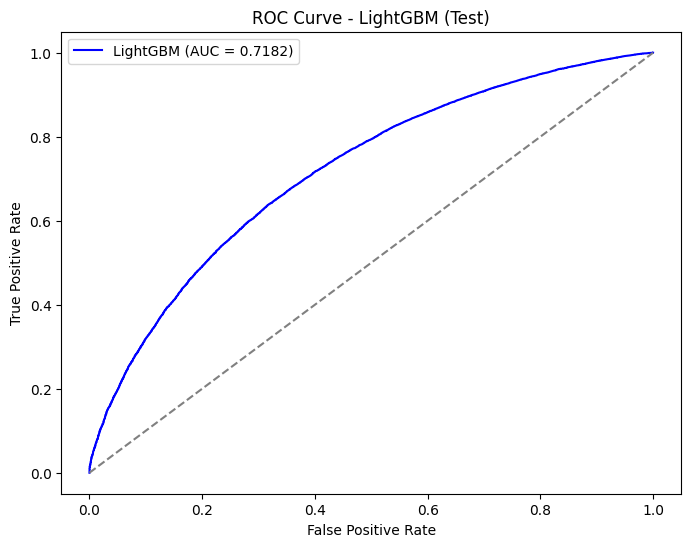

In [114]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'LightGBM (AUC = {test_roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LightGBM (Test)')
plt.legend()
plt.show()

In [115]:
feature_importance = pd.Series(lgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nFeature Importance:\n", feature_importance)


Feature Importance:
 dti                            8551
revol_util                     8208
int_rate                       7509
annual_inc                     7343
active_credit_pct              7093
installment_to_income_ratio    6717
total_interest_owed            6462
loan_to_income                 5996
credit_age                     5174
mort_acc                       2187
emp_length                     2157
purpose                        1100
grade                           463
verification_status             437
home_ownership                  299
pub_rec                         272
initial_list_status             169
pub_rec_bankruptcies            150
term                            149
dtype: int32


# Model Building using XGBoost Classifier

In [116]:
xgb_model_df = model_df.copy()

In [117]:
cols = list(xgb_model_df.columns)

for col in cols:
    if xgb_model_df[col].dtype=='category' or xgb_model_df[col].dtype=='object':
        xgb_model_df[col] = xgb_model_df[col].astype(str)
        xgb_model_df[col]=le.fit_transform(xgb_model_df[col])

xgb_model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316326 entries, 0 to 316325
Data columns (total 21 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   term                         316326 non-null  int64  
 1   int_rate                     316326 non-null  float64
 2   grade                        316326 non-null  int64  
 3   emp_length                   316326 non-null  int64  
 4   home_ownership               316326 non-null  int64  
 5   annual_inc                   316326 non-null  float64
 6   verification_status          316326 non-null  int64  
 7   purpose                      316326 non-null  int64  
 8   dti                          316326 non-null  float64
 9   pub_rec                      316326 non-null  int64  
 10  revol_util                   316326 non-null  float64
 11  initial_list_status          316326 non-null  int64  
 12  mort_acc                     316326 non-null  float64
 13 

In [118]:
xgb_model_df["temp_id"] = range(len(xgb_model_df))

X = xgb_model_df.drop(columns=['loan_status'])
y = xgb_model_df['loan_status']

In [119]:
xgb_model_df = xgb_model_df.sample(frac=1, random_state=42).reset_index(drop=True)

train_ids, test_ids = train_test_split(
    xgb_model_df["temp_id"], test_size=0.2, random_state=42
)

X_train = X.loc[X["temp_id"].isin(train_ids)].drop(columns=['temp_id'])
X_test = X.loc[X["temp_id"].isin(test_ids)].drop(columns=['temp_id'])
y_train = y.loc[X["temp_id"].isin(train_ids)]
y_test = y.loc[X["temp_id"].isin(test_ids)]

X.drop(columns=['temp_id'], inplace=True)

In [120]:
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
print(scale_pos_weight)

0.2451166589582862


# Hyperparameter Tuning using RandomizedSearchCV

In [121]:
param_distributions = {
    "n_estimators": [int(x) for x in np.linspace(start=100, stop=1500, num=10)],
    "max_depth": [3, 5, 7, 9],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "gamma": [0, 0.01, 0.1, 0.2],
    "reg_alpha": [0, 0.01, 0.1, 1.0],
    "reg_lambda": [0, 0.01, 0.1, 1.0],
}

In [122]:
xgb_clf = xgb.XGBClassifier(
    random_state=42,
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="gpu_hist", 
    gpu_id=0,  
    scale_pos_weight=scale_pos_weight  
)

In [123]:
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_distributions,
    n_iter=30, 
    scoring='roc_auc',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1,
    return_train_score=True
)

In [124]:
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_
print("\n Best Parameters:", random_search.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits

 Best Parameters: {'subsample': 1.0, 'reg_lambda': 0, 'reg_alpha': 0.1, 'n_estimators': 722, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0.2, 'colsample_bytree': 0.6}


In [125]:
y_train_pred = best_model.predict(X_train)
y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]

train_accuracy = accuracy_score(y_train, y_train_pred)
print("\n Train Accuracy:", train_accuracy)

train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
print("\n Train AUC-ROC Score:", train_roc_auc)

print("\n Train Classification Report:\n", classification_report(y_train, y_train_pred))


 Train Accuracy: 0.6790207855844463

 Train AUC-ROC Score: 0.7519314238151471

 Train Classification Report:
               precision    recall  f1-score   support

           0       0.34      0.69      0.46     49818
           1       0.90      0.68      0.77    203242

    accuracy                           0.68    253060
   macro avg       0.62      0.68      0.62    253060
weighted avg       0.79      0.68      0.71    253060



In [126]:
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

test_accuracy = accuracy_score(y_test, y_pred)
print("\n Test Accuracy:", test_accuracy)

test_roc_auc = roc_auc_score(y_test, y_pred_proba)
print("\n Test AUC-ROC Score:", test_roc_auc)

print("\n Test Classification Report:\n", classification_report(y_test, y_pred))


 Test Accuracy: 0.6636740113172952

 Test AUC-ROC Score: 0.7237723927225892

 Test Classification Report:
               precision    recall  f1-score   support

           0       0.32      0.66      0.43     12405
           1       0.89      0.67      0.76     50861

    accuracy                           0.66     63266
   macro avg       0.61      0.66      0.60     63266
weighted avg       0.78      0.66      0.70     63266



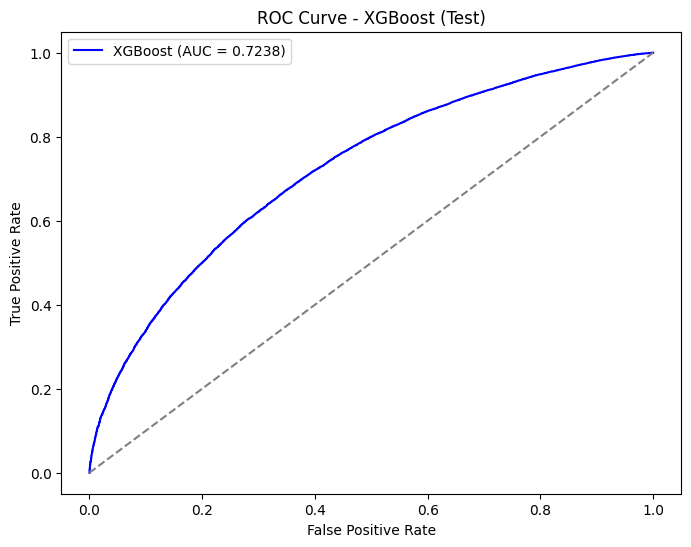

In [127]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'XGBoost (AUC = {test_roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost (Test)')
plt.legend()
plt.show()

In [128]:
feature_importance = pd.Series(best_model.feature_importances_, index=X.columns).sort_values(ascending=False)
print(feature_importance)

grade                          0.487644
term                           0.132010
int_rate                       0.071117
home_ownership                 0.039150
dti                            0.029251
loan_to_income                 0.028220
annual_inc                     0.024260
emp_length                     0.021410
mort_acc                       0.020595
total_interest_owed            0.019938
verification_status            0.018259
active_credit_pct              0.014786
initial_list_status            0.014710
installment_to_income_ratio    0.014415
pub_rec                        0.014121
purpose                        0.013937
revol_util                     0.012878
pub_rec_bankruptcies           0.011907
credit_age                     0.011390
dtype: float32


# Prediction Data

In [129]:
prediction_df = pd.read_csv('/kaggle/input/rocket-mortgage/test (1).csv')
prediction_df.shape

(79060, 27)

In [130]:
prediction_df.head()

,Unnamed: 0,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,0,14000.0,36 months,11.14,459.28,B,B2,Frederick's of Hollywood,10+ years,RENT,...,11.0,0.0,35366.0,48.1,23.0,w,INDIVIDUAL,0.0,0.0,"050 Charles Stream Suite 336\r\nNew Jerryland,..."
1,1,10000.0,36 months,12.99,336.90,B,B5,Parts Sales,3 years,MORTGAGE,...,6.0,1.0,6073.0,65.3,12.0,f,INDIVIDUAL,0.0,1.0,"1212 Pitts Oval\r\nMeyermouth, OH 22690"
2,2,6000.0,36 months,11.67,198.35,B,B4,secretary,10+ years,RENT,...,18.0,1.0,4926.0,39.4,49.0,f,INDIVIDUAL,6.0,1.0,"0843 Price Creek Suite 444\r\nThomashaven, WA ..."
3,3,6500.0,36 months,15.59,227.21,D,D1,Dental Assistant,2 years,RENT,...,11.0,0.0,3100.0,50.0,22.0,w,INDIVIDUAL,0.0,0.0,"27041 Angela Forges Suite 641\r\nWelchmouth, O..."
4,4,9500.0,36 months,12.12,316.09,B,B3,Wake County Public Schools,9 years,RENT,...,9.0,0.0,19246.0,57.8,26.0,f,INDIVIDUAL,0.0,0.0,"PSC 4021, Box 3568\r\nAPO AP 22690"


In [131]:
get_null_percentage(prediction_df)

mort_acc                9.585125
emp_title               5.728561
emp_length              4.585125
title                   0.454086
pub_rec_bankruptcies    0.132811
revol_util              0.079686
dtype: float64

**Preprocessing on prediction data**

In [132]:
prediction_df['mort_acc'] = prediction_df.apply(fill_mort_acc, axis=1)

drop_cols = ['title', 'emp_title', 'address', 'issue_d']
prediction_df.drop(columns=[c for c in drop_cols if c in prediction_df.columns], inplace=True)

prediction_df['emp_length'] = prediction_df['emp_length'].apply(convert_emp_length)
prediction_df['emp_length'].fillna("Unknown", inplace=True)

if 'annual_inc' in prediction_df.columns and 'loan_amnt' in prediction_df.columns:
    prediction_df['loan_to_income'] = prediction_df['loan_amnt'] / prediction_df['annual_inc']

if 'installment' in prediction_df.columns and 'annual_inc' in prediction_df.columns:
    prediction_df['installment_to_income_ratio'] = prediction_df['installment'] / (prediction_df['annual_inc'] / 12)

if 'total_acc' in prediction_df.columns and 'open_acc' in prediction_df.columns:
    prediction_df['active_credit_pct'] = prediction_df.apply(
        lambda row: row['open_acc'] / row['total_acc'] if row['total_acc'] > 0 else np.nan,
        axis=1
    )

if 'earliest_cr_line' in prediction_df.columns:
    prediction_df['earliest_cr_line'] = pd.to_datetime(prediction_df['earliest_cr_line'], errors='coerce')
    current_year = pd.Timestamp('now').year
    prediction_df['credit_age'] = current_year - prediction_df['earliest_cr_line'].dt.year
    prediction_df.drop('earliest_cr_line', axis=1, inplace=True)

if 'pub_rec' in prediction_df.columns:
    prediction_df['pub_rec'] = prediction_df['pub_rec'].apply(lambda x: '0' if x == 0 else ('1' if x == 1 else '2+'))

if 'pub_rec_bankruptcies' in prediction_df.columns:
    prediction_df['pub_rec_bankruptcies'] = prediction_df['pub_rec_bankruptcies'].apply(lambda x: '0' if x == 0 else ('1' if x == 1 else '2+'))

if 'loan_amnt' in prediction_df.columns and 'int_rate' in prediction_df.columns:
    prediction_df['total_interest_owed'] = prediction_df['loan_amnt'] * (prediction_df['int_rate'] / 100)

In [133]:
needed_cols = ['term', 'int_rate', 'grade', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'purpose', 'dti', 'pub_rec',
       'revol_util', 'initial_list_status', 'mort_acc', 'pub_rec_bankruptcies',
       'loan_to_income', 'total_interest_owed', 'installment_to_income_ratio',
       'active_credit_pct', 'credit_age']

final_pred_df = prediction_df[needed_cols].copy()

# LightGBM Prediction

In [134]:
cat_cols = ['term', 'grade', 'emp_length', 'home_ownership', 'verification_status', 'purpose', 'pub_rec', 'initial_list_status', 'pub_rec_bankruptcies']

for col in cat_cols:
    if col in final_pred_df.columns:
        final_pred_df[col] = final_pred_df[col].astype('category')

In [135]:
get_null_percentage(final_pred_df)

revol_util    0.079686
dtype: float64

In [136]:
y_pred = lgb_model.predict(final_pred_df)
y_pred_proba = lgb_model.predict_proba(final_pred_df)[:, 1]
print("Predictions:", y_pred)
print("Prediction probabilities:", y_pred_proba)

Predictions: [1 0 1 ... 1 1 1]
Prediction probabilities: [0.59785752 0.48875454 0.75140345 ... 0.71624749 0.67973202 0.98135069]


In [137]:
data_counter = Counter(y_pred)
total = sum(data_counter.values())
percentages = {key: (value / total) * 100 for key, value in data_counter.items()}
print(percentages)

{1: 65.83733873007841, 0: 34.16266126992158}


# XGBoost Prediction

In [138]:
xgb_final_pred_df = final_pred_df.copy()

cols = list(xgb_final_pred_df.columns)

for col in cols:
    if xgb_final_pred_df[col].dtype=='category' or xgb_final_pred_df[col].dtype=='object':
        xgb_final_pred_df[col] = xgb_final_pred_df[col].astype(str)
        xgb_final_pred_df[col]=le.fit_transform(xgb_final_pred_df[col])

xgb_final_pred_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79060 entries, 0 to 79059
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   term                         79060 non-null  int64  
 1   int_rate                     79060 non-null  float64
 2   grade                        79060 non-null  int64  
 3   emp_length                   79060 non-null  int64  
 4   home_ownership               79060 non-null  int64  
 5   annual_inc                   79060 non-null  float64
 6   verification_status          79060 non-null  int64  
 7   purpose                      79060 non-null  int64  
 8   dti                          79060 non-null  float64
 9   pub_rec                      79060 non-null  int64  
 10  revol_util                   78997 non-null  float64
 11  initial_list_status          79060 non-null  int64  
 12  mort_acc                     79060 non-null  float64
 13  pub_rec_bankrupt

In [139]:
y_pred = best_model.predict(final_pred_df)
y_pred_proba = best_model.predict_proba(final_pred_df)[:, 1]
print("Predictions:", y_pred)
print("Prediction probabilities:", y_pred_proba)

Predictions: [1 1 1 ... 1 1 1]
Prediction probabilities: [0.6445897  0.56852734 0.6999468  ... 0.70222527 0.523836   0.9171023 ]


In [140]:
data_counter = Counter(y_pred)
total = sum(data_counter.values())
percentages = {key: (value / total) * 100 for key, value in data_counter.items()}
print(percentages)

{1: 60.078421452061725, 0: 39.921578547938275}


# SHAP Analysis on LightGBM Model

In [141]:
!pip install shap

In [142]:
import shap

In [143]:
final_features = list(final_pred_df.columns)

In [144]:
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_test)[1]

ValueError: train and valid dataset categorical_feature do not match.

In [ ]:
plt.figure()
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, plot_type="dot", show=False)
plt.title("SHAP Summary Dot Plot")
plt.show()

In [ ]:
plt.figure()
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, plot_type="bar", show=False)
plt.title("SHAP Summary Bar Plot")
plt.show()